In [1]:
import xarray as xr, pandas as pd
import numpy as np    
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.cm as colorm
import matplotlib.colorbar as colorbar
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from datetime import datetime,timedelta
#from eofs.xarray import Eof
from matplotlib.gridspec import GridSpec
from glob import glob
from scipy.io import readsav
from scipy import stats
import matplotlib.colors as colors
import functools
%matplotlib inline

In [2]:
def n_days_avg (array, year, month, startday, endday):
    a = array.sel(Time = slice(str(year).zfill(4)+'-'+str(month).zfill(2)+'-'+str(startday).zfill(2)\
                              ,str(year).zfill(4)+'-'+str(month).zfill(2)+'-'+str(endday).zfill(2))).mean(dim='Time')
    a = a.expand_dims('Time')
    a['Time'] = pd.date_range(str(year).zfill(4)+'-'+str(month).zfill(2)+'-'+str((startday+endday)//2).zfill(2),periods=1,freq='H')
    return a

In [3]:
def monte_carlo(sample1, sample2):
    N=10000
    sample1 = sample1[np.isfinite(sample1)]
    sample2 = sample2[np.isfinite(sample2)]
    sample = np.append(sample1,sample2)
    s1 = np.size(sample1)
    xbar = np.ones(N)
    for i in range (N):
        np.random.shuffle(sample)
        xbar[i] = np.nanmean(sample[:s1])-np.nanmean(sample[s1:])
    p = len(np.where(xbar<=(sample1.mean()-sample2.mean()))[0])/float(N)
    return p

In [4]:
def SAT(temp,pr): #calculate the saturation h2o mixing ratio 
    esi=np.zeros(np.shape(temp),dtype='f')
    i_h2o=np.where(temp>273.15)
    n_h2o=np.size(i_h2o)
    if n_h2o>0:
        esi[i_h2o]=np.exp(54.842763-6763.22/temp[i_h2o]-4.210*np.log(temp[i_h2o])\
        +0.000367*temp[i_h2o]+np.tanh(0.0415*(temp[i_h2o]-218.8))\
        *(53.878-1331.22/temp[i_h2o])-9.44523*np.log(temp[i_h2o]+0.014025*temp[i_h2o]))/100.
    i_ice=np.where((temp>0.0) & (temp<273.15))
    n_ice=np.size(i_ice)
    if n_ice>0:
        esi[i_ice]=np.exp(9.550426-5723.265/temp[i_ice]+3.53068*np.log(temp[i_ice])\
        -0.00728332*temp[i_ice])/100.0
    h2o=esi/(pr-esi)
    high=np.where((esi*100-pr)<0)
    nh=np.size(high)
    if nh>0:
        h2o[high]=(esi/pr)[high]
    return h2o*1.0e6

In [5]:
def anml(x):
    l = len(x)
    mean = np.nanmean(np.nanmean(x.reshape([12,l//12//6,6]),axis=0),axis=1)
    return (x.reshape([12,l//12//6,6])-mean[np.newaxis,:,np.newaxis]).reshape(l)

In [6]:
def significance_test(a,b,sig_level=0.975,auto_correlation = True):
    if auto_correlation:
        aa,bb = np.polyfit(a,b,1)
        residual = (b-aa*a-bb)
        x = (residual)
        z = np.correlate(x,x,mode='full')
        z = z[len(z)//2:]
        lag1 = z[1]/z.max()
        df = (len(a)*(1-lag1)/(1+lag1))-2
    else:
        df = len(a)
    r = np.corrcoef(a,b)[0,1]
    t = r*np.sqrt(df)/np.sqrt(1-r**2)
   
    if t>stats.t.ppf(sig_level,df):
        print ('Significance test passed')
    else:
        print  ('not significant')
    return 1-stats.t.cdf(t,df)

In [7]:
from functools import wraps
import time
def timethis(func):
    '''
    Decorator that reports the execution time.
    '''
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(func.__name__, end-start)
        return result
    return wrapper

In [8]:
def add_order(ax,num):
    ymin,ymax = ax.get_ylim()
    xmin,xmax = ax.get_xlim()
    plt.text(xmin-(xmax-xmin)*0.08,ymax+(ymax-ymin)*0.015,\
            '('+chr(65+num)+')',fontsize=16,fontweight='semibold')

# Read data

## GridRad


In [9]:
year = 2005
filename = '/mnt/data/sn2/wyu/mls/convection/NEXRAD_convection_occurance_grided_hourly_'+str(year).zfill(4)+'05_pressure_level.nc'
f = xr.open_dataset(filename)
f['Time'] = pd.date_range('2005-05-01',periods=len(f['Time']),freq='H')
conv_may = f.Conv_pr
f.close()
for i in range (11):
    year = i+2006
    filename = '/mnt/data/sn2/wyu/mls/convection/NEXRAD_convection_occurance_grided_hourly_'+str(year).zfill(4)+'05_pressure_level.nc'
    f = xr.open_dataset(filename)
    f['Time'] = pd.date_range(str(year).zfill(4)+'-05-01',periods=len(f['Time']),freq='H')
    conv_may = xr.concat([conv_may,f.Conv_pr],dim='Time')
    f.close()
conv_may['Lev'] = np.floor(conv_may.Lev)

In [10]:
year = 2005
filename = '/mnt/data/sn2/wyu/mls/convection/NEXRAD_convection_occurance_grided_hourly_'+str(year).zfill(4)+'07_pressure_level.nc'
f = xr.open_dataset(filename)
f['Time'] = pd.date_range('2005-07-01',periods=len(f['Time']),freq='H')
conv_jul = f.Conv_pr
f.close()
for i in range (11):
    year = i+2006
    filename = '/mnt/data/sn2/wyu/mls/convection/NEXRAD_convection_occurance_grided_hourly_'+str(year).zfill(4)+'07_pressure_level.nc'
    f = xr.open_dataset(filename)
    f['Time'] = pd.date_range(str(year).zfill(4)+'-07-01',periods=len(f['Time']),freq='H')
    conv_jul = xr.concat([conv_jul,f.Conv_pr],dim='Time')
    f.close()
conv_jul['Lev'] = np.floor(conv_jul.Lev)

In [11]:
year = 2005
filename = '/mnt/data/sn2/wyu/mls/convection/NEXRAD_convection_occurance_grided_hourly_'+str(year).zfill(4)+'08_pressure_level.nc'
f = xr.open_dataset(filename)
f['Time'] = pd.date_range('2005-08-01',periods=len(f['Time']),freq='H')
conv_aug = f.Conv_pr
f.close()
for i in range (11):
    year = i+2006
    filename = '/mnt/data/sn2/wyu/mls/convection/NEXRAD_convection_occurance_grided_hourly_'+str(year).zfill(4)+'08_pressure_level.nc'
    f = xr.open_dataset(filename)
    f['Time'] = pd.date_range(str(year).zfill(4)+'-08-01',periods=len(f['Time']),freq='H')
    conv_aug = xr.concat([conv_aug,f.Conv_pr],dim='Time')
    f.close()
conv_aug['Lev'] = np.floor(conv_aug.Lev)

In [12]:
year = 2005
filename = '/mnt/data/sn2/wyu/mls/convection/NEXRAD_convection_occurance_grided_hourly_'+str(year).zfill(4)+'06_pressure_level.nc'
f = xr.open_dataset(filename)
f['Time'] = pd.date_range('2005-06-01',periods=len(f['Time']),freq='H')
conv_jun = f.Conv_pr
f.close()
for i in range (11):
    year = i+2006
    filename = '/mnt/data/sn2/wyu/mls/convection/NEXRAD_convection_occurance_grided_hourly_'+str(year).zfill(4)+'06_pressure_level.nc'
    f = xr.open_dataset(filename)
    f['Time'] = pd.date_range(str(year).zfill(4)+'-06-01',periods=len(f['Time']),freq='H')
    conv_jun = xr.concat([conv_jun,f.Conv_pr],dim='Time')
    f.close()

conv_jun['Lev'] = np.floor(conv_jun.Lev)

In [13]:
conv_5days = n_days_avg(conv_jun,2005,6,1,5)
for i in range(5):
    conv_5days = xr.concat([conv_5days, n_days_avg(conv_jun,2005,6,i*5+6,i*5+10)],dim='Time')
for i in range(5):
    conv_5days = xr.concat([conv_5days, n_days_avg(conv_jul,2005,7,i*5+1,i*5+5)],dim='Time')
conv_5days = xr.concat([conv_5days, n_days_avg(conv_jul,2005,7,26,31)],dim='Time')
for i in range(5):
    conv_5days = xr.concat([conv_5days, n_days_avg(conv_aug,2005,8,i*5+1,i*5+5)],dim='Time')
conv_5days = xr.concat([conv_5days, n_days_avg(conv_aug,2005,8,26,31)],dim='Time')

for j in range(11):
    year = j+2006
    for i in range(6):
        conv_5days = xr.concat([conv_5days, n_days_avg(conv_jun,year,6,i*5+1,i*5+5)],dim='Time')
    for i in range(5):
        conv_5days = xr.concat([conv_5days, n_days_avg(conv_jul,year,7,i*5+1,i*5+5)],dim='Time')
    conv_5days = xr.concat([conv_5days, n_days_avg(conv_jul,year,7,26,31)],dim='Time')
    for i in range(5):
        conv_5days = xr.concat([conv_5days, n_days_avg(conv_aug,year,8,i*5+1,i*5+5)],dim='Time')
    conv_5days = xr.concat([conv_5days, n_days_avg(conv_aug,year,8,26,31)],dim='Time')


In [14]:
conv_5days_lead1 = n_days_avg(conv_may,2005,5,26,31)
for i in range(6):
    conv_5days_lead1 = xr.concat([conv_5days_lead1, n_days_avg(conv_jun,2005,6,i*5+1,i*5+5)],dim='Time')
for i in range(5):
    conv_5days_lead1 = xr.concat([conv_5days_lead1, n_days_avg(conv_jul,2005,7,i*5+1,i*5+5)],dim='Time')
conv_5days_lead1 = xr.concat([conv_5days_lead1, n_days_avg(conv_jul,2005,7,26,31)],dim='Time')
for i in range(5):
    conv_5days_lead1 = xr.concat([conv_5days_lead1, n_days_avg(conv_aug,2005,8,i*5+1,i*5+5)],dim='Time')

for j in range(11):
    year = j+2006
    conv_5days_lead1 = xr.concat([conv_5days_lead1, n_days_avg(conv_may,year,5,26,31)],dim='Time')
    for i in range(6):
        conv_5days_lead1 = xr.concat([conv_5days_lead1, n_days_avg(conv_jun,year,6,i*5+1,i*5+5)],dim='Time')
    for i in range(5):
        conv_5days_lead1 = xr.concat([conv_5days_lead1, n_days_avg(conv_jul,year,7,i*5+1,i*5+5)],dim='Time')
    conv_5days_lead1 = xr.concat([conv_5days_lead1, n_days_avg(conv_jul,year,7,26,31)],dim='Time')
    for i in range(5):
        conv_5days_lead1 = xr.concat([conv_5days_lead1, n_days_avg(conv_aug,year,8,i*5+1,i*5+5)],dim='Time')


In [15]:
conv_5days_lead2 = n_days_avg(conv_may,2005,5,21,25)
conv_5days_lead2 = xr.concat([conv_5days_lead2, n_days_avg(conv_may,2005,5,26,31)],dim='Time')
for i in range(6):
    conv_5days_lead2 = xr.concat([conv_5days_lead2, n_days_avg(conv_jun,2005,6,i*5+1,i*5+5)],dim='Time')
for i in range(5):
    conv_5days_lead2 = xr.concat([conv_5days_lead2, n_days_avg(conv_jul,2005,7,i*5+1,i*5+5)],dim='Time')
conv_5days_lead2 = xr.concat([conv_5days_lead2, n_days_avg(conv_jul,2005,7,26,31)],dim='Time')
for i in range(4):
    conv_5days_lead2 = xr.concat([conv_5days_lead2, n_days_avg(conv_aug,2005,8,i*5+1,i*5+5)],dim='Time')

for j in range(11):
    year = j+2006
    conv_5days_lead2 = xr.concat([conv_5days_lead2, n_days_avg(conv_may,year,5,21,25)],dim='Time')
    conv_5days_lead2 = xr.concat([conv_5days_lead2, n_days_avg(conv_may,year,5,26,31)],dim='Time')
    for i in range(6):
        conv_5days_lead2 = xr.concat([conv_5days_lead2, n_days_avg(conv_jun,year,6,i*5+1,i*5+5)],dim='Time')
    for i in range(5):
        conv_5days_lead2 = xr.concat([conv_5days_lead2, n_days_avg(conv_jul,year,7,i*5+1,i*5+5)],dim='Time')
    conv_5days_lead2 = xr.concat([conv_5days_lead2, n_days_avg(conv_jul,year,7,26,31)],dim='Time')
    for i in range(4):
        conv_5days_lead2 = xr.concat([conv_5days_lead2, n_days_avg(conv_aug,year,8,i*5+1,i*5+5)],dim='Time')


In [16]:
conv_5days_lead3 = n_days_avg(conv_may,2005,5,16,20)
conv_5days_lead3 = xr.concat([conv_5days_lead3, n_days_avg(conv_may,2005,5,21,25)],dim='Time')
conv_5days_lead3 = xr.concat([conv_5days_lead3, n_days_avg(conv_may,2005,5,26,31)],dim='Time')
for i in range(6):
    conv_5days_lead3 = xr.concat([conv_5days_lead3, n_days_avg(conv_jun,2005,6,i*5+1,i*5+5)],dim='Time')
for i in range(5):
    conv_5days_lead3 = xr.concat([conv_5days_lead3, n_days_avg(conv_jul,2005,7,i*5+1,i*5+5)],dim='Time')
conv_5days_lead3 = xr.concat([conv_5days_lead3, n_days_avg(conv_jul,2005,7,26,31)],dim='Time')
for i in range(3):
    conv_5days_lead3 = xr.concat([conv_5days_lead3, n_days_avg(conv_aug,2005,8,i*5+1,i*5+5)],dim='Time')

for j in range(11):
    year = j+2006
    for i in range(2):
        conv_5days_lead3 = xr.concat([conv_5days_lead3, n_days_avg(conv_may,year,5,16+i*5,20+i*5)],dim='Time')
    conv_5days_lead3 = xr.concat([conv_5days_lead3, n_days_avg(conv_may,year,5,26,31)],dim='Time')
    for i in range(6):
        conv_5days_lead3 = xr.concat([conv_5days_lead3, n_days_avg(conv_jun,year,6,i*5+1,i*5+5)],dim='Time')
    for i in range(5):
        conv_5days_lead3 = xr.concat([conv_5days_lead3, n_days_avg(conv_jul,year,7,i*5+1,i*5+5)],dim='Time')
    conv_5days_lead3 = xr.concat([conv_5days_lead3, n_days_avg(conv_jul,year,7,26,31)],dim='Time')
    for i in range(3):
        conv_5days_lead3 = xr.concat([conv_5days_lead3, n_days_avg(conv_aug,year,8,i*5+1,i*5+5)],dim='Time')


## MLS

In [17]:
year = 2005
filename = '/mnt/data/sn2/wyu/mls/satellite/MLS_h2o_grided_daily_'+str(year).zfill(4)+'.nc'
f = xr.open_dataset(filename)
f['Time'] = pd.date_range('2005-01-01',periods=len(f['Time']),freq='D')
h2o_may = f.H2o_mix.sel(Time=slice(str(year).zfill(4)+'-05-01',str(year).zfill(4)+'-05-31'))
h2o_jul = f.H2o_mix.sel(Time=slice(str(year).zfill(4)+'-07-01',str(year).zfill(4)+'-07-31'))
h2o_jun = f.H2o_mix.sel(Time=slice(str(year).zfill(4)+'-06-01',str(year).zfill(4)+'-06-30'))
h2o_aug = f.H2o_mix.sel(Time=slice(str(year).zfill(4)+'-08-01',str(year).zfill(4)+'-08-31'))
h2o_sep = f.H2o_mix.sel(Time=slice(str(year).zfill(4)+'-09-01',str(year).zfill(4)+'-09-30'))

for i in range (11):
    year = i+2006
    filename = '/mnt/data/sn2/wyu/mls/satellite/MLS_h2o_grided_daily_'+str(year).zfill(4)+'.nc'
    f = xr.open_dataset(filename)
    f['Time'] = pd.date_range(str(year).zfill(4)+'-01-01',periods=len(f['Time']),freq='D')
    h2o_may = xr.concat([h2o_may,f.H2o_mix.sel(Time=slice(str(year).zfill(4)+'-05-01',str(year).zfill(4)+'-05-31'))],dim='Time')
    h2o_jul = xr.concat([h2o_jul,f.H2o_mix.sel(Time=slice(str(year).zfill(4)+'-07-01',str(year).zfill(4)+'-07-31'))],dim='Time')
    h2o_jun = xr.concat([h2o_jun,f.H2o_mix.sel(Time=slice(str(year).zfill(4)+'-06-01',str(year).zfill(4)+'-06-30'))],dim='Time')
    h2o_aug = xr.concat([h2o_aug,f.H2o_mix.sel(Time=slice(str(year).zfill(4)+'-08-01',str(year).zfill(4)+'-08-31'))],dim='Time')
    h2o_sep = xr.concat([h2o_sep,f.H2o_mix.sel(Time=slice(str(year).zfill(4)+'-09-01',str(year).zfill(4)+'-09-30'))],dim='Time')
h2o_may['Lev'] = np.floor(h2o_may.Lev)
h2o_jul['Lev'] = np.floor(h2o_jul.Lev)
h2o_jun['Lev'] = np.floor(h2o_jun.Lev)
h2o_aug['Lev'] = np.floor(h2o_aug.Lev)
h2o_sep['Lev'] = np.floor(h2o_sep.Lev)

In [18]:
h2o_5days = n_days_avg(h2o_jun,2005,6,1,5)
for i in range(5):
    h2o_5days = xr.concat([h2o_5days, n_days_avg(h2o_jun,2005,6,i*5+6,i*5+10)],dim='Time')
for i in range(5):
    h2o_5days = xr.concat([h2o_5days, n_days_avg(h2o_jul,2005,7,i*5+1,i*5+5)],dim='Time')
h2o_5days = xr.concat([h2o_5days, n_days_avg(h2o_jul,2005,7,26,31)],dim='Time')
for i in range(5):
    h2o_5days = xr.concat([h2o_5days, n_days_avg(h2o_aug,2005,8,i*5+1,i*5+5)],dim='Time')
h2o_5days = xr.concat([h2o_5days, n_days_avg(h2o_aug,2005,8,26,31)],dim='Time')

for j in range(11):
    year = j+2006
    for i in range(6):
        h2o_5days = xr.concat([h2o_5days, n_days_avg(h2o_jun,year,6,i*5+1,i*5+5)],dim='Time')
    for i in range(5):
        h2o_5days = xr.concat([h2o_5days, n_days_avg(h2o_jul,year,7,i*5+1,i*5+5)],dim='Time')
    h2o_5days = xr.concat([h2o_5days, n_days_avg(h2o_jul,year,7,26,31)],dim='Time')
    for i in range(5):
        h2o_5days = xr.concat([h2o_5days, n_days_avg(h2o_aug,year,8,i*5+1,i*5+5)],dim='Time')
    h2o_5days = xr.concat([h2o_5days, n_days_avg(h2o_aug,year,8,26,31)],dim='Time')


/h/yuwandi/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## ERAi temperature 

In [19]:
temp_tro_avg = np.zeros([12,4,6])
temp_tro_hist = np.zeros([12,3,10])
months = [str(i+5).zfill(2) for i in range(4)]
years = [str(i+2005) for i in range(12)]
temp_mins1 = np.zeros(12)
for i,year in enumerate(years):
    for j,month in enumerate(months): 
        f = xr.open_dataset('/mnt/data/ice2/wyu/ERAi_100/temp_100hPa_'+year+month+'_tro.nc')
        f.close()
        temp_tro_avg[i,j] = f.T.mean(dim=['Lat','Lon']).values[:30].reshape([6,5]).mean(axis=-1)
temp_tro_avg = temp_tro_avg.reshape([12,24])[:,5:-1].flatten()  

temp_mins = np.zeros(12)
for i,year in enumerate(years):
    for j in range(3): 
        month1,month2 = months[j],months[j+1]
        f1 = xr.open_dataset('/mnt/data/ice2/wyu/ERAi_100/temp_100hPa_'+year+month1+'_tro.nc')
        f2 = xr.open_dataset('/mnt/data/ice2/wyu/ERAi_100/temp_100hPa_'+year+month2+'_tro.nc')
        f1.close()
        f2.close()
        f = xr.concat([f1,f2],dim='Time')
        f = f.isel(Time = slice(26,57))
        if j == 0:
            temp_mins[i] = f.T.mean()
        temps = np.zeros(10)
        for k in range(10):
            temps[k] = len(np.where(f.T.values.flatten()>k+190)[0])
        temp_tro_hist[i,j,:9] = temps[:-1]-temps[1:]
        temp_tro_hist[i,j,-1] = temps[-1]


# trajectory result 

In [20]:
def grid_and_count(lon, lat, lonGrid, latGrid):
    import numpy as np
    nlatGrid  = len(latGrid)                           # the number of latitude grids
    nlonGrid  = len(lonGrid)                           # the number of longitude grids
    latStep   = latGrid[1] - latGrid[0]                # calculate the latstep for the regular latitudes
    lonStep   = lonGrid[1] - lonGrid[0]                # calculate the lonstep for the regular longitude

    #s  = varin.squeeze().shape
    varout = np.zeros([np.size(lonGrid),np.size(latGrid)])#*np.nan    
    for i in range(nlonGrid):
        for j in range(nlatGrid):
            lon_low = lonGrid[i]-lonStep/2.0 ; lon_high = lonGrid[i]+lonStep/2.0
            lat_low = latGrid[j]-latStep/2.0 ; lat_high = latGrid[j]+latStep/2.0
            iH = np.where(((lon >= lon_low) & (lon < lon_high)) & ((lat >= lat_low) & (lat < lat_high)))
            if len(iH[0]) != 0:
                varout[i, j] = len(iH[0])
    return varout.T

In [21]:
fbackfile = '/mnt/data/ice2/wyu/back_traj_result_test/MLS_backtrajectories_init100_NEXRAD_ERAi_{}{}_'.format('2010','08')
fbackfiles = glob(fbackfile+'10days_25_E*.nc')
lonGrid = np.arange(230,291,2)
latGrid = np.arange(25,51,2)
lonGrid2 = np.arange(245,291,1)
latGrid2 = np.arange(25,50,1)
months = [str(i+6).zfill(2) for i in range(3)]
years = [str(i+2005) for i in range(12)]
grid_conv = np.zeros([12,3,13,31])
grid_conv2 = np.zeros([12,3,25,46])
for i,year in enumerate(years):
    for j,month in enumerate(months):
        f = xr.open_dataset('/mnt/data//sn2/wyu/mls/encounter_events/encounter_events{}{}_230W_lineartropo_25N.nc'.format(year,month))
        fMLS = xr.open_dataset('/mnt/data/ice2/wyu/mls_l2/MLS_L2_H2O_O3_{}{}_NA.nc'.format(year,month))
        grid_conv[i,j] = grid_and_count(f.lon, f.lat, lonGrid, latGrid)
        grid_conv2[i,j] = grid_and_count(f.lon, f.lat, lonGrid2, latGrid2)
        

In [22]:
def cal_ratio(threshold):
    i_over = np.where(conv_jun.sel(Lev=100).values.mean(axis=0)>threshold)
    a = grid_conv2.mean(axis=0)[0][i_over].sum()/grid_conv2.mean(axis=0)[0].sum()
    i_over = np.where(conv_jul.sel(Lev=100).values.mean(axis=0)>threshold)
    b = grid_conv2.mean(axis=0)[1][i_over].sum()/grid_conv2.mean(axis=0)[1].sum()
    i_over = np.where(conv_aug.sel(Lev=100).values.mean(axis=0)>threshold)
    c = grid_conv2.mean(axis=0)[2][i_over].sum()/grid_conv2.mean(axis=0)[2].sum()
    return a,b,c

In [23]:
ratios = np.zeros([10,3])
for i in range(10):
    ratios[i]  = cal_ratio((i+1)*1e-6)

In [24]:
ratios[5]

array([0.32309273, 0.50237413, 0.48692938])

In [25]:
fbackfile = '/mnt/data/ice2/wyu/back_traj_result_test/MLS_backtrajectories_init100_NEXRAD_ERAi_{}{}_'.format('2010','08')
fbackfiles = glob(fbackfile+'10days_25_E*.nc')

months = [str(i+6).zfill(2) for i in range(3)]
years = [str(i+2005) for i in range(12)]
h2os_conv = []
h2os_noconv = []
o3s_conv = []
o3s_noconv = []
fback = xr.open_dataset(fbackfiles[0])
for i,year in enumerate(years):
    for j,month in enumerate(months):
        f = xr.open_dataset('/mnt/data/sn2/wyu/mls/encounter_events/encounter_events{}{}_230W_lineartropo_25N.nc'.format(year,month))
        fMLS = xr.open_dataset('/mnt/data/ice2/wyu/mls_l2/MLS_L2_H2O_O3_{}{}_NA.nc'.format(year,month))
        h2os_conv.append(fMLS.h2o[list(set(f.index.values)),12].values)
        i_noconv = [ii for ii in range(len(fMLS.index)) if (ii not in f.index and fMLS.longitude[ii]>240)]
        h2os_noconv.append(fMLS.h2o[i_noconv,12].values)
        
        o3s_conv.append(fMLS.o3[list(set(f.index.values)),12].values)
        i_noconv = [ii for ii in range(len(fMLS.index)) if (ii not in f.index and fMLS.longitude[ii]>240)]
        o3s_noconv.append(fMLS.o3[i_noconv,12].values)

In [26]:
n_noconv,n_conv = np.zeros([12,3,13]),np.zeros([12,3,13])
n_o3_noconv,n_o3_conv = np.zeros([12,3,13]),np.zeros([12,3,13])

for j in range(12):
    for t in range(3):
        for i in range(13):
            n_conv[j,t,i] = len(np.where(np.all([h2os_conv[j*3+t]>i+1,\
                                h2os_conv[j*3+t]<i+2],axis=0))[0])
            n_noconv[j,t,i] = len(np.where(np.all([h2os_noconv[j*3+t]>i+1,\
                                h2os_noconv[j*3+t]<i+2],axis=0))[0])
            n_o3_conv[j,t,i] = len(np.where(np.all([o3s_conv[j*3+t]>(i+1)*0.1,\
                                o3s_conv[j*3+t]<(i+2)*0.1],axis=0))[0])
            n_o3_noconv[j,t,i] = len(np.where(np.all([o3s_noconv[j*3+t]>(i+1)*0.1,\
                                o3s_noconv[j*3+t]<(i+2)*0.1],axis=0))[0])
n_noconv = n_noconv.sum(axis=0)
n_conv = n_conv.sum(axis=0)
n_o3_noconv = n_o3_noconv.sum(axis=0)
n_o3_conv = n_o3_conv.sum(axis=0)


/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


In [27]:
#@timethis
def grid_and_count(lon, lat, lonGrid, latGrid):
    import numpy as np
    nlatGrid  = len(latGrid)                           # the number of latitude grids
    nlonGrid  = len(lonGrid)                           # the number of longitude grids
    latStep   = latGrid[1] - latGrid[0]                # calculate the latstep for the regular latitudes
    lonStep   = lonGrid[1] - lonGrid[0]                # calculate the lonstep for the regular longitude

    #s  = varin.squeeze().shape
    varout = np.zeros([np.size(lonGrid),np.size(latGrid)])#*np.nan    
    for i in range(nlonGrid):
        for j in range(nlatGrid):
            lon_low = lonGrid[i]-lonStep/2.0 ; lon_high = lonGrid[i]+lonStep/2.0
            lat_low = latGrid[j]-latStep/2.0 ; lat_high = latGrid[j]+latStep/2.0
            iH = np.where(((lon >= lon_low) & (lon < lon_high)) & ((lat >= lat_low) & (lat < lat_high)))
            if len(iH[0]) != 0:
                varout[i, j] = len(iH[0])
    return varout.T

In [28]:
grid_mls = np.zeros([12,3,13,31])
grid_e_mls = np.zeros([12,3,13,31])
#grid_encounter = np.zeros([12,3,21,26])
lonGrid = np.arange(230,291,2)
latGrid = np.arange(25,51,2)
fbackfile = '/mnt/data/ice2/wyu/back_traj_result_test/MLS_backtrajectories_init100_NEXRAD_ERAi_{}{}_'.format('2010','08')
fbackfiles = glob(fbackfile+'10days_25_E*.nc')
e_encounter_times = np.zeros([12,3])
encounter_times = np.zeros([12,3])
months = [str(i+6).zfill(2) for i in range(3)]
years = [str(i+2005) for i in range(12)]

for i,year in enumerate(years):
    for j,month in enumerate(months):
        f = xr.open_dataset('/mnt/data/sn2/wyu/mls/encounter_events/encounter_events{}{}_230W_lineartropo_25N.nc'.format(year,month))
        fMLS = xr.open_dataset('/mnt/data/ice2/wyu/mls_l2/MLS_L2_{}{}_NA.nc'.format(year,month))
        h2omins = np.zeros(len(f.index.values))
        for k in range(len(set(f.index.values))):
            i_num = np.where(f.index.values==list(set(f.index.values))[k])
            h2omins[i_num] = np.nanmean(f.h2o_mins[i_num])
        i_5day = np.where(f.conv_times>=120)[0]
        i_5day_h2omins = np.where(f.conv_times[h2omins>5]>=120)[0]
        grid_mls[i,j] = grid_and_count(fMLS.longitude[list(set(f.index.values[i_5day]))].values,fMLS.latitude\
                                          [list(set(f.index.values[i_5day]))].values, lonGrid, latGrid)/\
                            grid_and_count(fMLS.longitude.values,fMLS.latitude\
                                          .values, lonGrid, latGrid)
        grid_e_mls[i,j] = grid_and_count(fMLS.longitude[list(set(f.index.values[i_5day_h2omins]))].values,fMLS.latitude\
                                          [list(set(f.index.values[i_5day_h2omins]))].values, lonGrid, latGrid)/\
                            grid_and_count(fMLS.longitude.values,fMLS.latitude\
                                          .values, lonGrid, latGrid)
        
        encounter_times[i,j] = len(list(set(f.index[i_5day].values)))
        e_encounter_times[i,j] = len(set(f.index[i_5day_h2omins].values))
grid_mls[np.isnan(grid_mls)] = 0 
grid_e_mls[np.isnan(grid_e_mls)] = 0 

/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


In [29]:
months = [str(i+6).zfill(2) for i in range(3)]
years = [str(i+2005) for i in range(12)]
histories = np.zeros([12,3,13,31])
for i,year in enumerate(years):
    for j,month in enumerate(months):
        f = xr.open_dataset('/mnt/data/sn2/wyu/mls/parcel_history/parcel_history'+year+month+'_MLS_grided_center.nc')
        histories[i,j] = f.Parcel_history.values
lon = f.Lon.values
lat = f.Lat.values
f.close()

In [30]:
months = [str(i+6).zfill(2) for i in range(3)]
years = [str(i+2005) for i in range(12)]
encounter_ratio_5days = np.zeros([10,12,3,6])

for i,year in enumerate(years):
    for j,month in enumerate(months):
        f = xr.open_dataset('/mnt/data/sn2/wyu/mls/encounter_events/encounter_events{}{}_230W_lineartropo_25N.nc'.format(year,month))
        fMLS = xr.open_dataset('/mnt/data/ice2/wyu/mls_l2/MLS_L2_{}{}_NA.nc'.format(year,month))
        h2o_mins = np.zeros(len(f.index.values))
        for k in range(len(list(set(f.index.values)))):
            i_num = np.where(f.index==list(set(f.index.values))[k])[0]
            h2o_mins[i_num] = np.nanmean(f.h2o_mins[i_num])
        for k in range(10):
            i_encounter = np.where(np.all([f.conv_times>=120,h2o_mins>k+1],axis=0))[0]
            for t in range(6):
                days = fMLS.day[list(set(f.index.values[i_encounter]))].values
                totaldays = fMLS.day.values
                i_date = len(np.where(np.all([days>t*5,days<=(t+1)*5],axis=0))[0])
                i_total_date = len(np.where(np.all([totaldays>t*5,totaldays<=(t+1)*5],axis=0))[0])
                encounter_ratio_5days[k,i,j,t] = i_date/i_total_date
    

In [31]:
months = [str(i+6).zfill(2) for i in range(3)]
years = [str(i+2005) for i in range(12)]
h2o_mins = np.zeros([12,3,11])
lat_mins = np.zeros([12,3,11])
temp_mins = np.zeros([12,3,11])
for i,year in enumerate(years):
    for j,month in enumerate(months):
        f = xr.open_dataset('/mnt/data/sn2/wyu/mls/encounter_events/encounter_events{}{}_230W_lineartropo_25N.nc'.format(year,month))
        fMLS = xr.open_dataset('/mnt/data/ice2/wyu/mls_l2/MLS_L2_{}{}_NA.nc'.format(year,month))
        i_5day = np.where(f.conv_times>=120)[0]
        f.close()
        h2o_index_mins = np.zeros(len(list(set(f.index.values[i_5day]))))
        lat_index_mins = np.zeros(len(list(set(f.index.values[i_5day]))))
        temp_index_mins = np.zeros(len(list(set(f.index.values[i_5day]))))
        for t in range(len(list(set(f.index.values[i_5day])))):
            h2o_index_mins[t] = np.mean(f.h2o_mins[np.where(f.index.values==list(set(f.index.values[i_5day]))[t])[0]])
            lat_index_mins[t] = np.mean(f.lowest_lats[np.where(f.index.values==list(set(f.index.values[i_5day]))[t])[0]])
            temp_index_mins[t] = np.mean(f.temp_mins[np.where(f.index.values==list(set(f.index.values[i_5day]))[t])[0]])
        h2os = np.arange(11)
        lats = np.arange(11)
        temps = np.arange(11)
        for t in range(11):
            h2os[t] = len(np.where(h2o_index_mins>t+1)[0])
            lats[t] = len(np.where(lat_index_mins>t*2.5+10)[0])
            temps[t] = len(np.where(temp_index_mins>t+190)[0])
        '''
        h2os = np.arange(11)
        for t in range(11):
            h2os[t] = len(np.where(f.h2o_mins.values[i_5day]>t+1)[0])
        '''
        h2o_mins[i,j,:10] = h2os[:-1]-h2os[1:]
        lat_mins[i,j,:10] = lats[:-1]-lats[1:]
        temp_mins[i,j,:10] = temps[:-1]-temps[1:]
        h2o_mins[i,j,-1] = h2os[-1]
        lat_mins[i,j,-1] = lats[-1]
        temp_mins[i,j,-1] = temps[-1]
        

In [32]:
months = [str(i+6).zfill(2) for i in range(3)]
years = [str(i+2005) for i in range(12)]
#months = ['06']
# years = ['2010']
troh2o = np.array([])
nontroh2o = np.array([])
tro_ratio = np.zeros([12,3])
for i,year in enumerate(years):
    for j,month in enumerate(months):
        f = xr.open_dataset('/mnt/data/sn2/wyu/mls/encounter_events/encounter_events{}{}_230W_25N.nc'.format(year,month))
        fMLS = xr.open_dataset('/mnt/data/ice2/wyu/mls_l2/MLS_L2_{}{}_NA.nc'.format(year,month))
        i_tro = f.index.values[np.where(f.lowest_lats.values<20)[0]]
        tro_ratio[i,j]=(len(i_tro)/len(f.index.values))
        
#         i_non_tro = f.index.values[np.where(f.lowest_lats.values>20)[0]]
#         if len(i_tro):
#             troh2o=np.append(troh2o,fMLS.h2o[i_tro,12].values)
#         nontroh2o=np.append(nontroh2o,fMLS.h2o[i_non_tro,12].values)
        

In [33]:
tro_ratio.mean(axis=0)

array([0.33073205, 0.13474571, 0.09129535])

In [34]:
monte_carlo(troh2o,nontroh2o)

/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice.
  # This is added back by InteractiveShellApp.init_path()
/h/yuwandi/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()


0.0

In [35]:
print (np.mean(troh2o))
print (np.mean(nontroh2o))

nan
nan


/h/yuwandi/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [40]:
print (np.median(troh2o))
print (np.median(nontroh2o))

nan
nan


In [36]:
months = [str(i+6).zfill(2) for i in range(3)]
years = [str(i+2005) for i in range(12)]
history_ratio = np.zeros([12,3,30])
for i,year in enumerate(years):
    for j,month in enumerate(months):
        f = xr.open_dataset('/mnt/data/sn2/wyu/mls/parcel_history/parcel_history'+year+month+'_MLS_daily_trajback.nc')
        for t in range(30):
            #ratio[i,j,t] = len(np.where(f.parcel_history[t]>120)[0])
            history_ratio[i,j,t] = f.parcel_history[t].mean().values
history_ratio = np.nanmean(history_ratio.reshape([12,3,6,5]),axis=-1).flatten()
history_ratio = (history_ratio-history_ratio.mean())/history_ratio.std()

/h/yuwandi/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [37]:
months = [str(i+6).zfill(2) for i in range(3)]
years = [str(i+2005) for i in range(12)]
history_days = np.zeros([12,3,10])
for i,year in enumerate(years):
    for j,month in enumerate(months):
        f = xr.open_dataset('/mnt/data/sn2/wyu/mls/parcel_history/parcel_history'+year+month+'_MLS_daily_trajback.nc')
        day = f.parcel_history.values.flatten()//24
        for t in range(10):
            history_days[i,j,t] = len(np.where(day==t+1)[0])


In [38]:
months = [str(i+6).zfill(2) for i in range(3)]
years = [str(i+2005) for i in range(12)]
year,month = years[0],months[0]
o3_jun = xr.concat([xr.open_dataset('/mnt/data/ice2/wyu/mls_o3_grided/MLS_o3_grided_{}{}.nc'.format(year,months[0])) for year in years],dim='Time')
o3_jul = xr.concat([xr.open_dataset('/mnt/data/ice2/wyu/mls_o3_grided/MLS_o3_grided_{}{}.nc'.format(year,months[1])) for year in years],dim='Time')
o3_aug = xr.concat([xr.open_dataset('/mnt/data/ice2/wyu/mls_o3_grided/MLS_o3_grided_{}{}.nc'.format(year,months[2])) for year in years],dim='Time')



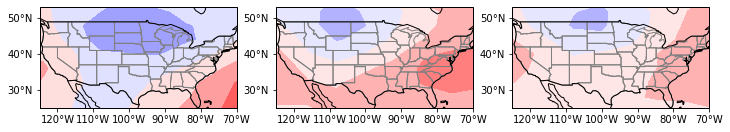

In [39]:
o3s = [o3_jun-o3_jun.mean(dim='Lon'),o3_jul-o3_jul.mean(dim='Lon')\
       ,o3_aug-o3_aug.mean(dim='Lon')]
plt.figure(figsize=[12,6])
for i in range(3):
    o3 = o3s[i]
    ax1 = plt.subplot(1,3,i+1,projection=ccrs.PlateCarree(central_longitude=0)) 
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.add_feature(cfeature.STATES, edgecolor='grey')
    ax1.add_feature(cfeature.BORDERS, edgecolor='black')
    ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.set_extent((235,290,25,50))   
    ax1.set_yticks([30, 40, 50], crs=ccrs.PlateCarree())
    ax1.set_xticks([240,250, 260, 270, 280, 290], crs=ccrs.PlateCarree())
    cx = ax1.contourf(o3.Lon.values,o3.Lat.values,o3.O3.mean(dim='Time').sel(Lev=100).values\
            ,vmax=0.2,vmin=-0.2,cmap='bwr',transform=ccrs.PlateCarree())
    #plt.colorbar(cx)

# plotting 

## fig.1

In [109]:
def h2o_conv_slope(i_fig,ax,am,cm,bm,title,co,cmax=1.05,amax=1.5,amin=-0.4,num=1):
    a1,a2,b1,b2 = bootstrap_test_fit(cm,am,0.95,method='margin of error')
    ax.plot([0,num],np.array([0,num])*a1+b1,color=co,linestyle='--')
    ax.plot([0,num],np.array([0,num])*a2+b2,color=co,linestyle='--')
    ax.set_title(title,fontsize=16)
    ax.set_xlabel('Convection occurrence (*$10^{-5}$)',fontsize=14)
    if i_fig==0:
        ax.set_ylabel(r'$H_2O$'+' anomaly (ppmv)',fontsize=14)
    aa,bb = np.polyfit(cm,am,1)
    ax.plot([0,num],np.array([0,num])*aa+bb,color=co,linestyle='-')
    ax.plot(cm,am,'o',color=co,label='slope=%.4s'%aa+u"\u00B1"+'%.4s'%(a2-aa))
    
#     cmap = colorm.Blues
#     bmax = 198
#     bmin = 192
#     colors_array = cmap((bm-bmin)/(bmax-bmin))
#     rainbow = [colors.rgb2hex(i) for i in colors_array]
#     for i in range(len(cm)):
#         ax.plot(cm[i],am[i],'o',color=rainbow[i])
#    ax.plot(cm[i],am[i],'o',co)
    #plt.plot(cm[30:35],am[30:35],'o',color='grey',label='2010')
    ax.legend(fontsize=12,loc=2)
    #significance_test(cm,am,sig_level=0.95)
    ax.set_ylim(amin,amax)
    ax.set_xlim(-0.05,cmax)
    ax.text(-0.1,amax+(amax-amin)*0.04,'('+chr(65+i_fig+1)+')',fontsize=16,fontweight='semibold')

In [110]:
def bootstrap_test_fit(c,d,p,method='significant'):
    results = np.zeros([10000,2])
    for j in range(10000):
        i = np.random.randint(len(c),size=len(c))
        slope,intercept = np.polyfit(c[i],d[i],1)
        results[j] = [slope,intercept]
    if method == 'significant':
        b1 = np.percentile(results[:,1],(1-p)/2.*100)
        b2 = np.percentile(results[:,1],(1+p)/2.*100)
        a1 = np.percentile(results[:,0],(1-p)/2.*100)
        a2 = np.percentile(results[:,0],(1+p)/2.*100)
    if method =='std':
        aa, bb = np.polyfit(c,d,1)
        a1 = aa-np.std(results[:,0])
        a2 = aa+np.std(results[:,0])
        p = 0.68
        b1 = np.percentile(results[:,1],(1-p)/2.*100)
        b2 = np.percentile(results[:,1],(1+p)/2.*100)
    if method == 'margin of error':
        aa,bb = np.polyfit(c,d,1)
        residual = (d-aa*c-bb)
        x = (residual)
        z = np.correlate(x,x,mode='full')
        z = z[len(z)//2:]
        lag1 = z[1]/z.max()
        df = (len(c)*(1-lag1)/(1+lag1))-2
        margin_of_error = np.std(results[:,0])*stats.t.ppf(0.95,int(df))
        a1 = aa-margin_of_error
        a2 = aa+margin_of_error
        p = 0.68
        b1 = np.percentile(results[:,1],(1-p)/2.*100)
        b2 = np.percentile(results[:,1],(1+p)/2.*100)
    return a1,a2,b1,b2

In [111]:
mh2o = (((h2o_5days).sel(Lev=100,Lon=slice(240,290), Lat=slice(25,50)).\
        mean(dim=['Lat','Lon'])-(h2o_5days).sel(Lev=100, Lat=slice(25,50)).\
        mean(dim=['Lat','Lon'])).values)
mconv = conv_5days.sel(Lat=slice(25,49)).mean(dim=['Lat','Lon']).sel(Lev=100).values
mconv_lead1 = conv_5days_lead1.sel(Lat=slice(25,49)).mean(dim=['Lat','Lon']).sel(Lev=100).values
mconv_lead2 = conv_5days_lead2.sel(Lat=slice(25,49)).mean(dim=['Lat','Lon']).sel(Lev=100).values
c = ((mconv+mconv_lead1)/2)
d = (mh2o)

In [36]:
mh2o1 = ((h2o_5days).sel(Lev=100,Lon=slice(240,290), Lat=slice(25,50)).\
        mean(dim=['Lat','Lon']).values)
mh2o2 = ((((h2o_5days).sel(Lev=100, Lat=slice(25,50)).\
        mean(dim=['Lat','Lon'])).values))

h2o1 = np.append(mh2o1.reshape([12,18]),np.ones([12,1])*np.nan,axis=1).reshape(12*19)
h2o2 = np.append(mh2o2.reshape([12,18]),np.ones([12,1])*np.nan,axis=1).reshape(12*19)
num = 228

In [35]:
cn0 = c*1e5
dn0 = d
e = (encounter_ratio_5days[0].flatten())
en0 = e
e1 = (encounter_ratio_5days[5].flatten())
en1 = e1

cn = np.append(cn0.reshape([12,18]),np.ones([12,1])*np.nan,axis=1).reshape(12*19)
dn = np.append(dn0.reshape([12,18]),np.ones([12,1])*np.nan,axis=1).reshape(12*19)
en = np.append(en0.reshape([12,18]),np.ones([12,1])*np.nan,axis=1).reshape(12*19)
num = 228

In [92]:
def cal_ylim(x):
    std = np.std(x)
    mean = np.mean(x)
    ylim = [mean-std*2.5, mean+std*5.5]
    return ylim

In [93]:
def set_axis(ax1,xx):
    std = np.std(xx)
    mean = np.mean(xx)
    f = lambda y,x: y+[0+x+2005,6/19+x+2005,12/19+x+2005]
    ticks = functools.reduce(f,[[]]+[i for i in range(12)])
    f = lambda y,x: y+[str(x+2005),'','']
    labels = functools.reduce(f,[[]]+[j for j in range(12)])
    ax1.set_xticks(ticks);
    ax1.set_xticklabels(labels);

    ax1.text(2004.5,5.7*std+mean,'('+chr(65)+')',fontsize=16,fontweight='semibold')

    for i in range(12):
        ax1.text(2005+i,-2.3*std+mean,'J')
        ax1.text(2005+i+0.33,-2.3*std+mean,'J')
        ax1.text(2005+i+0.67,-2.3*std+mean,'A')


/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


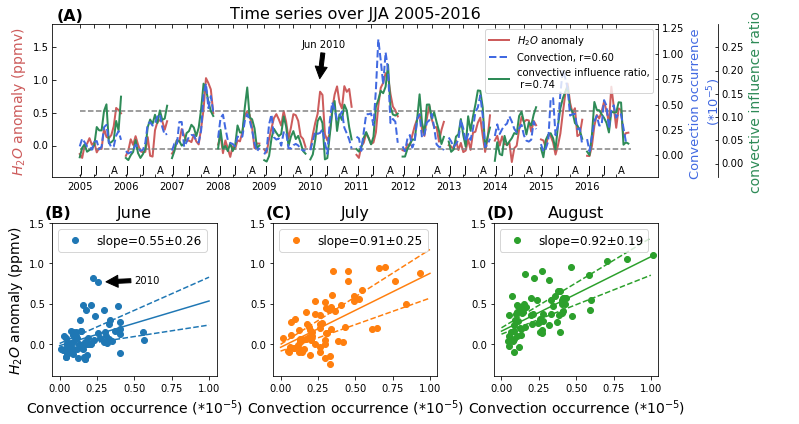

In [98]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(constrained_layout=True,figsize=[12,6])

gs = GridSpec(2, 3, figure=fig)

from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

ax1 = host_subplot(211, axes_class=AA.Axes)
plt.subplots_adjust(right=0.8)
ax0 = ax1.twinx()
ax2 = ax1.twinx()

new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
ax2.axis["right"] = new_fixed_axis(loc="right", axes=ax2)                                     
ax2.axis["right"].toggle(all=True)

new_fixed_axis = ax0.get_grid_helper().new_fixed_axis
ax0.axis["right"] = new_fixed_axis(loc="right", axes=ax0,offset=(60, 0))
ax0.axis["right"].toggle(all=True)


line1 = ax1.plot(np.arange(num)/(num//12)+2005,dn,label='$H_2O$ anomaly',color='indianred',linewidth=2)
ax1.plot(np.arange(num)/(num//12)+2005,np.ones(num)*(np.mean(dn0)-np.std(dn0)),linestyle='--',color='grey',label='standard deviation')
ax1.plot(np.arange(num)/(num//12)+2005,np.ones(num)*(np.mean(dn0)+np.std(dn0)),linestyle='--',color='grey')
line3 = ax0.plot(np.arange(num)/(num//12)+2005,en,label='effective encounter ratio',color='seagreen',linewidth=2)
line2 = ax2.plot(np.arange(num)/(num//12)+2005,cn,label='convection',color='royalblue',linestyle='--',linewidth=2)

ax2.axis["right"].label.set_fontsize(13)
ax0.axis["right"].label.set_fontsize(14)
ax1.axis["left"].label.set_fontsize(14)

ax1.set_ylabel('$H_2O$ anomaly (ppmv)',color='indianred')
ax2.set_ylabel('Convection occurrence \n(*$10^{-5}$)',color='royalblue')
ax0.set_ylabel('convective influence ratio',color='seagreen')

ax1.legend(line1+line2+line3,
           ['$H_2O$ anomaly','Convection, r=0.60',\
            'convective influence ratio,\n r=0.74','increase ratio'],
           loc=0,fontsize=10)
ax1.set_title('Time series over JJA 2005-2016',fontsize=16)
ax1.annotate('Jun 2010',xy = [2010.2,1.0],xytext=(2009.8, 1.5)\
             ,arrowprops=dict(facecolor='black', shrink=0.05),)
fig.add_axes(ax1)
ax1.set_ylim(cal_ylim(dn0))
ax2.set_ylim(cal_ylim(cn0))
ax0.set_ylim(cal_ylim(en0))


set_axis(ax1,dn0)


ax3 = fig.add_subplot(gs[-1, 0])
ax4 = fig.add_subplot(gs[-1, 1])
ax5 = fig.add_subplot(gs[-1, 2])

cos = ['#1f77b4','#ff7f0e','#2ca02c','w']
titles = ['June','July','August']
axs = [ax3,ax4,ax5]
for i in range(3):
    am = d.reshape([12,3,6])[:,i,:].reshape(12*6)
    cm = c.reshape([12,3,6])[:,i,:].reshape(12*6)*1e5
    bm = temp_tro_avg.reshape([12,3,6])[:,i,:].reshape(12*6)
    #print (np.corrcoef(am,cm)[0,1])
    #print (significance_test(am,bm))
    h2o_conv_slope(i,axs[i],am,cm,bm,titles[i],cos[i])
    
ax3.annotate('2010',xy = [0.3,0.77],xytext=(0.5, 0.75)\
             ,arrowprops=dict(facecolor='black', shrink=0.05),)
plt.tight_layout(rect = [0,0,0.9,1])
plt.savefig('/sn2/wyu/figures_for_monsoon_paper/fig1_new.pdf')

## Fig.2

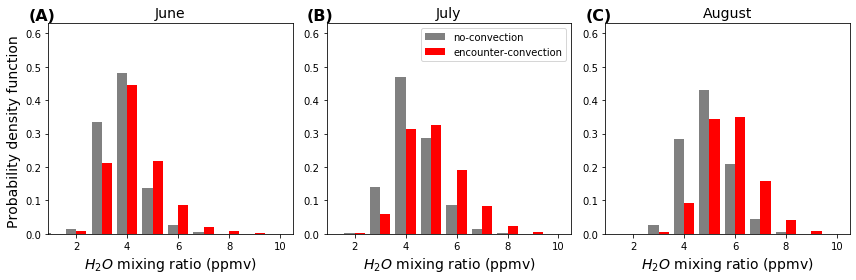

In [40]:
plt.figure(figsize=[12,4])
titles = ['June','July','August']
for j in range(3):
    ax = plt.subplot(1,3,j+1)
    plt.bar(np.arange(13)[0:9]+0.8,n_noconv[j,0:9]/n_noconv[j,0:9].sum(),width=0.4,label = 'no-convection',color='grey')
    plt.bar(np.arange(13)[0:9]+1.2,n_conv[j,0:9]/n_conv[j,0:9].sum(),width=0.4,label = 'encounter-convection',color='r')
#     plt.plot(np.arange(13)[0:9]+0.8,n_noconv[j,0:9]/n_noconv[j,0:9].sum(),label = 'no-convection',color='grey',linestyle='-',marker='o')
#     plt.plot(np.arange(13)[0:9]+1.2,n_conv[j,0:9]/n_conv[j,0:9].sum(),label = 'encounter-convection',color='r',linestyle='-',marker='o')

    if j == 1:
        plt.legend()
    plt.xlim(0.9,10.5)
    plt.ylim(0,0.63)
    plt.xlabel(r'$H_2O$ mixing ratio (ppmv)',fontsize=14)
    if j == 0:
        plt.ylabel('Probability density function ',fontsize=14)
    #plt.title('ratio of MLS observations over NA',fontsize=16)
    plt.title(titles[j],fontsize=14)
    add_order(ax,j) 
plt.tight_layout()
#plt.savefig('/sn2/wyu/figures_for_monsoon_paper/fig2.pdf')

## fig.3

In [44]:
def conv_plot(i,conv,title):
    co = 'Blues'
    lat=conv_jun.Lat.values
    lon=conv_jun.Lon.values
    levels = np.linspace(0,0.00004,50)
    levels2 = np.linspace(0,0.8,5)
    vmax = 3*1e-5
    ax1 = plt.subplot(5,3,i,projection=ccrs.PlateCarree(central_longitude=0)) 
    #ax1 = plt.subplot(fig.add_subplot(gs[0, i]),projection=ccrs.PlateCarree(central_longitude=0))
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.add_feature(cfeature.STATES, edgecolor='grey')
    ax1.add_feature(cfeature.BORDERS, edgecolor='black')
    ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.set_extent((230,290,25,50))   
    ax1.set_yticks([30, 40, 50], crs=ccrs.PlateCarree())
    ax1.set_xticks([230, 260, 290], crs=ccrs.PlateCarree())
    #plt.contour(lon,lat,conv.mean(dim='Time').sel(Lev=100).values,transform=ccrs.PlateCarree())
    ax1.pcolor(lon,lat,conv.mean(dim='Time').sel(Lev=100).values,cmap=co,vmax=vmax,transform=ccrs.PlateCarree())
    #CS = ax1.contour(h2o.Lon.values,h2o.Lat.values,h2o.mean(dim='Time').sel(Lev=100).values\
    #            ,levels=levels2,inline=True,colors='k',transform=ccrs.PlateCarree())
    #ax1.clabel(CS, inline=1, fmt='%1.1f',fontsize=10)
    CS1 = plt.contour(lon,lat,conv.mean(dim='Time').sel(Lev=100).values*1e6,levels=[10],colors='k',\
                     linewidths=2,transform=ccrs.PlateCarree())
    ax1.clabel(CS1, inline=1, fmt='%1.1f',fontsize=10)
    ax1.set_title(title,fontsize=14)

In [45]:
def h2o_plot(i_fig,conv,h2o,title):
    co = 'Blues'
    lat=conv.Lat.values
    lon=conv.Lon.values
    levels = np.linspace(0,0.00004,50)
    levels2 = np.linspace(-1.,1.,11)
    vmax = 0.000035
    ax1 = plt.subplot(5,3,i_fig,projection=ccrs.PlateCarree(central_longitude=0)) 
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.add_feature(cfeature.STATES, edgecolor='grey')
    ax1.add_feature(cfeature.BORDERS, edgecolor='black')
    ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.set_extent((230,290,25,50))   
    ax1.set_yticks([30, 40, 50], crs=ccrs.PlateCarree())
    ax1.set_xticks([230,240,250, 260, 270, 280, 290], crs=ccrs.PlateCarree())
    CS = plt.contour(lon,lat,conv.mean(dim='Time').sel(Lev=100).values,levels=[1e-5],colors='k',\
                     linewidths=2,transform=ccrs.PlateCarree())
    cx = ax1.contourf(h2o.Lon.values,h2o.Lat.values,h2o.mean(dim='Time').sel(Lev=100).values\
                ,levels=levels2,cmap='bwr',transform=ccrs.PlateCarree())
    #ax1.clabel(CS, inline=1, fmt='%1.1f',fontsize=10)
    ax1.set_title(title+' $H_2O$ anomaly',fontsize=14)
    return cx

In [46]:
def encounter_ratio_plot(i_fig,h2o,conv,lonGrid,latGrid,gridmls,title):
    vmax1 = 0.45
    lat=conv.Lat.values
    lon=conv.Lon.values
    ax1 = plt.subplot(5,3,i_fig,projection=ccrs.PlateCarree(central_longitude=0)) 
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.add_feature(cfeature.STATES, edgecolor='grey')
    ax1.add_feature(cfeature.BORDERS, edgecolor='black')
    ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.set_extent((230,290,25,50))   
    ax1.set_yticks([30, 40, 50], crs=ccrs.PlateCarree())
    ax1.set_xticks([230, 260, 290], crs=ccrs.PlateCarree())
    cx=plt.pcolor(lonGrid, latGrid,gridmls,cmap='YlOrRd',\
                  vmin=0,vmax=vmax1,transform=ccrs.PlateCarree())
    plt.title(title+' convective influence ratio',fontsize=12)
    levels2 = np.linspace(0,0.8,5)
    CS1 = plt.contour(lon,lat,conv.mean(dim='Time').sel(Lev=100).values,levels=[1e-5],colors='k',\
                     linewidths=2,transform=ccrs.PlateCarree())
    CS = ax1.contour(h2o.Lon.values,h2o.Lat.values,h2o.mean(dim='Time').sel(Lev=100).values\
                ,levels=levels2,linestyles='dashed',colors='k',transform=ccrs.PlateCarree(),linewidths = 1.5)
    #ax1.clabel(CS, inline=1, fmt='%1.1f',fontsize=13,colors='k')
    plt.text(220,56,'('+chr(64+i_fig)+')',fontsize=16,fontweight='semibold',transform=ccrs.PlateCarree())

In [47]:
def parcel_history_plot(i_fig,conv,lonGrid,latGrid,history,month,title):
    vmax2 = 11
    vmin = 0 
    lat=conv.Lat.values
    lon=conv.Lon.values
    ax1 = plt.subplot(5,3,i_fig,projection=ccrs.PlateCarree(central_longitude=0)) 
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.add_feature(cfeature.STATES, edgecolor='grey')
    ax1.add_feature(cfeature.BORDERS, edgecolor='black')
    ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.set_extent((230,290,25,50))   
    ax1.set_yticks([30, 40, 50], crs=ccrs.PlateCarree())
    ax1.set_xticks([230, 260, 290], crs=ccrs.PlateCarree())
    cx=plt.pcolor(lonGrid,latGrid,history,cmap='YlOrRd',\
                  vmin=0,vmax=vmax2,transform=ccrs.PlateCarree())
    plt.title(title+' NA residence time',fontsize=14)
    CS = plt.contour(lon,lat,conv.mean(dim='Time').sel(Lev=100).values,levels=[1e-5],colors='k',\
                     linewidths=2,transform=ccrs.PlateCarree())
    f = []
    for year in years:
        f += [xr.open_dataset('/mnt/data/ice2/wyu/ERAi_100/wind_100hPa_'+year+month+'_NA.nc')]
    X = f[0].Lon.values
    Y = f[0].Lat.values
    U = xr.concat([f[i].U for i in range(len(f))],dim='Time').mean(dim='Time').values
    V = xr.concat([f[i].V for i in range(len(f))],dim='Time').mean(dim='Time').values
    ax1.streamplot(X, Y, U, V, density=0.3, color='#333333',transform=ccrs.PlateCarree())
    plt.text(220,56,'('+chr(64+i_fig)+')',fontsize=16,fontweight='semibold',transform=ccrs.PlateCarree())

In [48]:
def conv_posi_plot(i_fig,lonGrid,latGrid,grid_conv,conv,h2o,title):
    ax1 = plt.subplot(5,3,i_fig,projection=ccrs.PlateCarree(central_longitude=0)) 
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.add_feature(cfeature.STATES, edgecolor='grey')
    ax1.add_feature(cfeature.BORDERS, edgecolor='black')
    ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.set_extent((230,290,25,50))   
    ax1.set_yticks([30, 40, 50], crs=ccrs.PlateCarree())
    ax1.set_xticks([230, 260, 290], crs=ccrs.PlateCarree())
    cx=plt.pcolor(lonGrid,latGrid,grid_conv,cmap='Blues',\
                  vmin=0,vmax=50*12,transform=ccrs.PlateCarree())
    CS = plt.contour(conv.Lon,conv.Lat,conv.mean(dim='Time').sel(Lev=100).values,levels=[1e-5],colors='k',\
                     linewidths=2,transform=ccrs.PlateCarree())
    levels2 = np.linspace(0,0.8,5)
    CS = ax1.contour(h2o.Lon.values,h2o.Lat.values,h2o.mean(dim='Time').sel(Lev=100).values\
                ,levels=levels2,linestyles='dashed',colors='k',transform=ccrs.PlateCarree(),linewidths = 1.5)
    plt.title(title+' location of\n convective encounters',fontsize=13)
    plt.text(220,56,'('+chr(64+i_fig)+')',fontsize=16,fontweight='semibold',transform=ccrs.PlateCarree())
    

/h/yuwandi/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


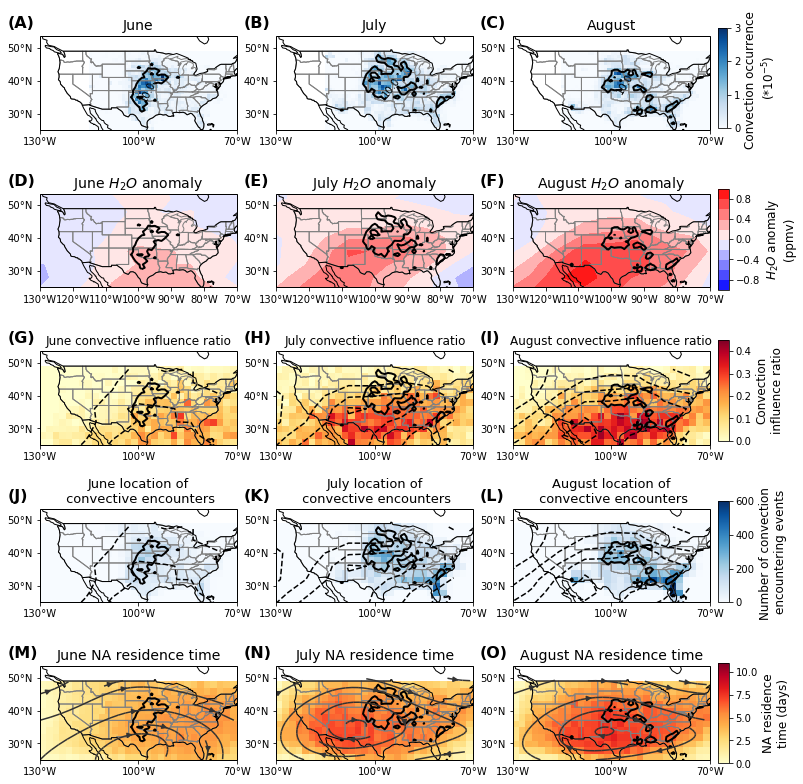

In [50]:
plt.figure(figsize=[12,14])
convs = [conv_jun,conv_jul,conv_aug]
h2os = [(h2o_jun-h2o_jun.mean(dim='Lon'))\
        ,(h2o_jul-h2o_jul.mean(dim='Lon'))\
          ,(h2o_aug-h2o_aug.mean(dim='Lon'))]
titles = ['June','July','August','September']


for i in range(3):
    conv_plot(i+1,convs[i],titles[i])
    plt.text(220,56,'('+chr(65+i)+')',fontsize=16,fontweight='semibold',transform=ccrs.PlateCarree())


for i in range(3):
    cx = h2o_plot(i+4,convs[i],h2os[i],titles[i])
    plt.text(220,56,'('+chr(64+i+4)+')',fontsize=16,fontweight='semibold',transform=ccrs.PlateCarree())
#     fs = glob('/mnt/data/ice2/wyu/mls_l2/MLS_*0{}_global.nc'.format(str(i+6)))
#     for ff in fs:
#         f = xr.open_dataset(ff)
#         i_over = np.where(f.h2o[:,12]>8)
#         plt.plot(f.longitude[i_over],f.latitude[i_over],'.',linewidth=0.01,
#         color='grey',transform=ccrs.PlateCarree())


h2os = [(h2o_jun-h2o_jun.mean(dim='Lon')).sel(Lon=slice(225,290), Lat=slice(10,50))\
        ,(h2o_jul-h2o_jul.mean(dim='Lon')).sel(Lon=slice(225,290), Lat=slice(10,50))\
          ,(h2o_aug-h2o_aug.mean(dim='Lon')).sel(Lon=slice(225,290), Lat=slice(10,50))]
lonGrid = np.arange(230,291,2)
latGrid = np.arange(25,51,2)

for i in range(3):
    conv_posi_plot(i+10,lonGrid,latGrid,grid_conv.sum(axis=0)[i],\
                   convs[i],h2os[i],titles[i])
for i in range(3):
    encounter_ratio_plot(i+7,h2os[i],convs[i],lonGrid,latGrid,(grid_mls[:,i]).mean(axis=0),titles[i])

for i in range(3):
    parcel_history_plot(i+13,convs[i],lonGrid,latGrid,np.nanmean(histories[:,i],axis=0)/24,str(i+6).zfill(2),titles[i])

cax = plt.axes([0.91, 0.77, 0.01, 0.1])
import matplotlib.cm as cm
cmap = cm.Blues
norm = colors.Normalize(vmin=0, vmax=3)
cb1 = colorbar.ColorbarBase(cax, cmap=cmap,norm=norm)
cb1.set_label('Convection occurrence \n'+r'$(*10^{-5})$',fontsize=12)    

vmax = 1
cax = plt.axes([0.91, 0.61, 0.012, 0.1])
cb1 = plt.colorbar(cx,cax=cax)
cb1.set_label(r'$H_2O$'+' anomaly\n(ppmv)',fontsize=12)


vmax1 = 0.45
vmax2 = 11
vmin = 0
cmap = cm.YlOrRd
cax = plt.axes([0.91, 0.46, 0.012, 0.1])
norm = colors.Normalize(vmin=0, vmax=vmax1)
cb1 = colorbar.ColorbarBase(cax, cmap=cmap,norm=norm)
cb1.set_label('Convection\ninfluence ratio',fontsize=12)
 
cax = plt.axes([0.91, 0.3, 0.012, 0.1])
cmap = cm.Blues
norm = colors.Normalize(vmin=0, vmax=50*12)
cb1 = colorbar.ColorbarBase(cax, cmap=cmap,norm=norm)
cb1.set_label('Number of convection \nencountering events',fontsize=12)

    
cax = plt.axes([0.91, 0.14, 0.012, 0.1])
cmap = cm.YlOrRd
norm = colors.Normalize(vmin=0, vmax=vmax2)
cb1 = colorbar.ColorbarBase(cax, cmap=cmap,norm=norm)
cb1.set_label('NA residence\ntime (days)',fontsize=12)
plt.tight_layout()
plt.savefig('/sn2/wyu/figures_for_monsoon_paper/fig3_new.pdf')

## fig. 4

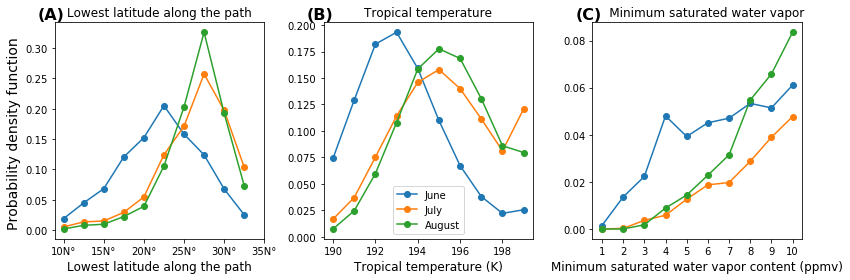

In [47]:
plt.figure(figsize=[12,4])
cos = ['#1f77b4','#ff7f0e','#2ca02c','w']
ax=plt.subplot(1,3,3)
plt.plot(np.arange(10)+1,(h2o_mins.sum(axis=0)[0]/h2o_mins[:,0].sum())[:10],label='June',color=cos[0],linestyle='-',marker='o')
plt.plot(np.arange(10)+1,(h2o_mins.sum(axis=0)[1]/h2o_mins[:,1].sum())[:10],label='July',color=cos[1],linestyle='-',marker='o')
plt.plot(np.arange(10)+1,(h2o_mins.sum(axis=0)[2]/h2o_mins[:,2].sum())[:10],label='August',color=cos[2],linestyle='-',marker='o')
plt.xticks(np.arange(10)+1,[str(i+1) for i in range(9)]+['10']);
plt.xlabel('Minimum saturated water vapor content (ppmv)',fontsize=12)
#plt.legend()
plt.title('     Minimum saturated water vapor',fontsize=12)
add_order(ax,2)

ax=plt.subplot(1,3,1)
plt.plot(np.arange(10)*2.5+10,(lat_mins.sum(axis=0)[0]/lat_mins[:,0].sum())[:10],label='June',color=cos[0],linestyle='-',marker='o')
plt.plot(np.arange(10)*2.5+10,(lat_mins.sum(axis=0)[1]/lat_mins[:,1].sum())[:10],label='July',color=cos[1],linestyle='-',marker='o')
plt.plot(np.arange(10)*2.5+10,(lat_mins.sum(axis=0)[2]/lat_mins[:,2].sum())[:10],label='August',color=cos[2],linestyle='-',marker='o')
plt.xticks(np.arange(6)*5+10,[str(i*5+10)+'N°' for i in range(6)]);
plt.xlabel('Lowest latitude along the path',fontsize=12)
plt.ylabel('Probability density function ', fontsize=14)
add_order(ax,0) 
#plt.legend()
#plt.ylabel('Probability density function ', fontsize=14)
plt.title('Lowest latitude along the path',fontsize=12)


ax=plt.subplot(1,3,2)
plt.plot(np.arange(10)+190,(temp_tro_hist.sum(axis=0)[0]/temp_tro_hist[:,0].sum())[:10],label='June',color=cos[0],linestyle='-',marker='o')
plt.plot(np.arange(10)+190,(temp_tro_hist.sum(axis=0)[1]/temp_tro_hist[:,1].sum())[:10],label='July',color=cos[1],linestyle='-',marker='o')
plt.plot(np.arange(10)+190,(temp_tro_hist.sum(axis=0)[2]/temp_tro_hist[:,2].sum())[:10],label='August',color=cos[2],linestyle='-',marker='o')
plt.xlabel('Tropical temperature (K)',fontsize=12)
#plt.ylabel('Probability density function ', fontsize=14)
add_order(ax,1) 
plt.legend()
plt.title('Tropical temperature',fontsize=12)
plt.tight_layout()
plt.savefig('/sn2/wyu/figures_for_monsoon_paper/fig4.pdf')

## fig. 6

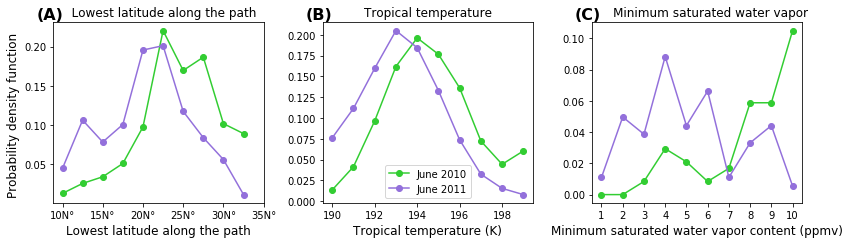

In [35]:
plt.figure(figsize=[12,3.5])

ax = plt.subplot(1,3,1)
#plt.bar(np.arange(10)*2.5+10-0.45*2.5,(lat_mins.sum(axis=0)[0]/lat_mins[:,0].sum())[:10],width=0.3*2.5,color='silver',label='June 2005-2016')
plt.plot(np.arange(10)*2.5+10,(lat_mins[5][0]/lat_mins[5,0].sum())[:10],color='limegreen',label='June 2010',linestyle='-',marker='o')
plt.plot(np.arange(10)*2.5+10,(lat_mins[6][0]/lat_mins[6,0].sum())[:10],color='mediumpurple',label='June 2011',linestyle='-',marker='o')
#plt.plot(np.arange(10)*2.5+10,(lat_mins.sum(axis=0)[0]/lat_mins[:,0].sum())[:10],label='June climatology',color='grey',linestyle='-',marker='.')

plt.xticks(np.arange(6)*5+10,[str(i*5+10)+'N°' for i in range(6)]);
plt.xlabel('Lowest latitude along the path',fontsize=12)
add_order(ax,0)
#plt.legend()
plt.ylabel('Probability density function ', fontsize=12)
plt.title('   Lowest latitude along the path',fontsize=12)

ax = plt.subplot(1,3,3)
#plt.bar(np.arange(10)+1-0.45,(h2o_mins.sum(axis=0)[0]/h2o_mins[:,0].sum())[:10],width=0.3,color='silver',label='June 2005-2016')
plt.plot(np.arange(10)+1,(h2o_mins[5][0]/h2o_mins[5,0].sum())[:10],color='limegreen',label='June 2010',linestyle='-',marker='o')
plt.plot(np.arange(10)+1,(h2o_mins[6][0]/h2o_mins[6,0].sum())[:10],color='mediumpurple',label='June 2011',linestyle='-',marker='o')
#plt.plot(np.arange(10)+1,(h2o_mins.sum(axis=0)[0]/h2o_mins[:,0].sum())[:10],label='June climatology',color='grey',linestyle='-',marker='.')
plt.xticks(np.arange(10)+1,[str(i+1) for i in range(9)]+['10']);
plt.xlabel('Minimum saturated water vapor content (ppmv)',fontsize=12)
#plt.legend()
plt.title('       Minimum saturated water vapor',fontsize=12)
add_order(ax,2)

# ax = plt.subplot(2,2,1)
# #plt.bar(np.arange(10)+1-0.45,(history_days.sum(axis=0)[0]/history_days[:,0].sum())[:10],width=0.3,color='silver',label='June 2005-2016')
# plt.bar(np.arange(10)+1-0.15,(history_days[5][0]/history_days[5,0].sum())[:10],width=0.3,color='limegreen',label='June 2010')
# plt.bar(np.arange(10)+1+0.15,(history_days[6][0]/history_days[6,0].sum())[:10],width=0.3,color='mediumpurple',label='June 2011')
# plt.xticks(np.arange(10)+1,[str(i+1) for i in range(9)]+['10+']);
# plt.xlabel('Parcel history (days)',fontsize=12)
# plt.legend()
# plt.ylabel('Probability density function ', fontsize=14)
# plt.title('Parcel history',fontsize=14)
# plt.tight_layout()
# add_order(ax,0)

ax = plt.subplot(1,3,2)
#plt.bar(np.arange(10)+190-0.45,(temp_tro_hist.sum(axis=0)[0]/temp_tro_hist[:,0].sum())[:10],width=0.3,color='silver',label='June 2005-2016')
plt.plot(np.arange(10)+190,(temp_tro_hist[5][0]/temp_tro_hist[5,0].sum())[:10],color='limegreen',label='June 2010',linestyle='-',marker='o')
plt.plot(np.arange(10)+190,(temp_tro_hist[6][0]/temp_tro_hist[6,0].sum())[:10],color='mediumpurple',label='June 2011',linestyle='-',marker='o')
#plt.plot(np.arange(10)+190,(temp_tro_hist.sum(axis=0)[0]/temp_tro_hist[:,0].sum())[:10],label='June climatology',color='grey',linestyle='-',marker='.')
#plt.xticks(np.arange(10)+1,[str(i+1) for i in range(9)]+['10']);
plt.xlabel('Tropical temperature (K)',fontsize=12)
plt.legend()
plt.title('Tropical temperature',fontsize=12)
add_order(ax,1)
plt.tight_layout()
plt.savefig('/sn2/wyu/figures_for_monsoon_paper/fig6.pdf')

## fig. 5

/h/yuwandi/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


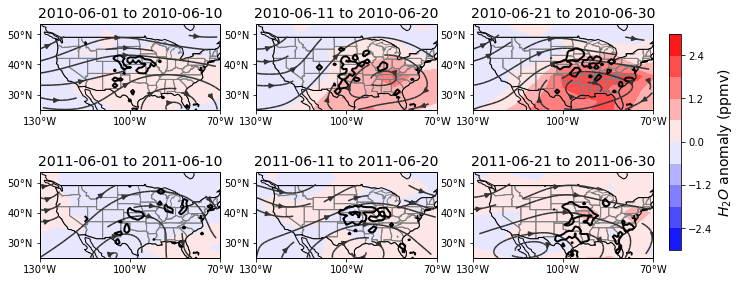

In [49]:
plt.figure(figsize=[11,5])
vmax = 3.
levels2 = np.linspace(-vmax,vmax,11)
year,month = '2010','06'
f = xr.open_dataset('/sn2/wyu/mls/encounter_events/encounter_events{}{}_30N.nc'.format(year,month))
fMLS = xr.open_dataset('/mnt/data/ice2/wyu/mls_l2/MLS_L2_{}{}_NA.nc'.format(year,month))
h2o_grid = (h2o_jun-h2o_jun.mean(dim='Lon')).sel(Lon=slice(220,300), \
        Lat=slice(20,60),Lev=100,Time=slice(year+'-06-01',year+'-06-30'))
conv_grid = conv_jun.sel(Time=slice(year+'-06-01',year+'-06-30'),Lev=100)
days = 10
for i in range(3):
    ax1 = plt.subplot(2,3,i+1,projection=ccrs.PlateCarree(central_longitude=0)) 
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.add_feature(cfeature.STATES, edgecolor='grey')
    ax1.add_feature(cfeature.BORDERS, edgecolor='black')
    ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.set_extent((230,290,25,50))   
    ax1.set_yticks([30, 40, 50], crs=ccrs.PlateCarree())
    ax1.set_xticks([230, 260, 290], crs=ccrs.PlateCarree())
    windFolder = '/co1/hao/reanlys_raw2nc/ECMWF_ERAi/winds/'
    f = xr.open_dataset('/mnt/data/ice2/wyu/ERAi_100/wind_100hPa_'+year+month+'_NA.nc')
    X = f.Lon.values
    Y = f.Lat.values
    U = f.U.sel(Time=slice(int(year)*10000+int(month)*100+i*days+1,int(year)*10000+int(month)*100+i*days+days)).mean(dim='Time').values
    V = f.V.sel(Time=slice(int(year)*10000+int(month)*100+i*days+1,int(year)*10000+int(month)*100+i*days+days)).mean(dim='Time').values
    ax1.streamplot(X, Y, U, V, density=0.3, color='#333333',transform=ccrs.PlateCarree())
    #conv_grid.sel(Time=slice('2010-06-15','2010-06-20')).mean(dim='Time').plot(transform=ccrs.PlateCarree(),cmap='Blues')
    #h2o_grid.sel(Time=slice('2010-06-20','2010-06-25')).mean(dim='Time').plot(transform=ccrs.PlateCarree())    
    CS = plt.contour(conv_grid.Lon,conv_grid.Lat,conv_grid.sel\
    (Time=slice(year+'-06-'+str(i*days+1).zfill(2),year+'-06-'+str((i+1)*days).zfill(2))).mean(dim='Time').values,
        levels=[1e-5],colors='k',linewidths=2,transform=ccrs.PlateCarree())
    cx = plt.contourf(h2o_grid.Lon,h2o_grid.Lat,h2o_grid.sel\
    (Time=slice(year+'-06-'+str(i*days+1).zfill(2),year+'-06-'+str((i+1)*days).zfill(2))).mean(dim='Time').values\
            ,levels=levels2,cmap='bwr',transform=ccrs.PlateCarree())
    plt.title(year+'-06-'+str(i*days+1).zfill(2)+' to '+year+'-06-'+str((i+1)*days).zfill(2), fontsize=14)

year,month = '2011','06'
f = xr.open_dataset('/sn2/wyu/mls/encounter_events/encounter_events{}{}_30N.nc'.format(year,month))
fMLS = xr.open_dataset('/mnt/data/ice2/wyu/mls_l2/MLS_L2_{}{}_NA.nc'.format(year,month))
h2o_grid = (h2o_jun-h2o_jun.mean(dim='Lon')).sel(Lon=slice(220,300), \
        Lat=slice(20,60),Lev=100,Time=slice(year+'-06-01',year+'-06-30'))
conv_grid = conv_jun.sel(Time=slice(year+'-06-01',year+'-06-30'),Lev=100)

for i in range(3):
    ax1 = plt.subplot(2,3,i+4,projection=ccrs.PlateCarree(central_longitude=0)) 
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.add_feature(cfeature.STATES, edgecolor='grey')
    ax1.add_feature(cfeature.BORDERS, edgecolor='black')
    ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.set_extent((230,290,25,50))   
    ax1.set_yticks([30, 40, 50], crs=ccrs.PlateCarree())
    ax1.set_xticks([230, 260, 290], crs=ccrs.PlateCarree())
    windFolder = '/co1/hao/reanlys_raw2nc/ECMWF_ERAi/winds/'
    f = xr.open_dataset('/mnt/data/ice2/wyu/ERAi_100/wind_100hPa_'+year+month+'_NA.nc')
    X = f.Lon.values
    Y = f.Lat.values
    U = f.U.sel(Time=slice(int(year)*10000+int(month)*100+i*days+1,int(year)*10000+int(month)*100+i*days+days)).mean(dim='Time').values
    V = f.V.sel(Time=slice(int(year)*10000+int(month)*100+i*days+1,int(year)*10000+int(month)*100+i*days+days)).mean(dim='Time').values
    ax1.streamplot(X, Y, U, V, density=0.3, color='#333333',transform=ccrs.PlateCarree())
    #conv_grid.sel(Time=slice('2010-06-15','2010-06-20')).mean(dim='Time').plot(transform=ccrs.PlateCarree(),cmap='Blues')
    #h2o_grid.sel(Time=slice('2010-06-20','2010-06-25')).mean(dim='Time').plot(transform=ccrs.PlateCarree())    
    CS = plt.contour(conv_grid.Lon,conv_grid.Lat,conv_grid.sel\
    (Time=slice(year+'-06-'+str(i*days+1).zfill(2),year+'-06-'+str((i+1)*days).zfill(2))).mean(dim='Time').values,
        levels=[1e-5],colors='k',linewidths=2,transform=ccrs.PlateCarree())
    cx = plt.contourf(h2o_grid.Lon,h2o_grid.Lat,h2o_grid.sel\
    (Time=slice(year+'-06-'+str(i*days+1).zfill(2),year+'-06-'+str((i+1)*days).zfill(2))).mean(dim='Time').values\
            ,levels=levels2,cmap='bwr',transform=ccrs.PlateCarree())
    plt.title(year+'-06-'+str(i*days+1).zfill(2)+' to '+year+'-06-'+str((i+1)*days).zfill(2), fontsize=14)

    
plt.tight_layout()
import matplotlib.cm as cm
cmap = cm.bwr
cax = plt.axes([0.92, 0.2, 0.015, 0.6])
cb1 = plt.colorbar(cx,cax=cax)
cb1.set_label('$H_2O$ anomaly (ppmv)',fontsize=14)
#plt.savefig('/sn2/wyu/figures_for_monsoon_paper/fig5.pdf')

In [37]:
def conv_plot(i,conv,title):
    co = 'Blues'
    lat=conv_jun.Lat.values
    lon=conv_jun.Lon.values
    levels = np.linspace(0,0.00004,50)
    levels2 = np.linspace(0,0.8,5)
    vmax = 3.5*1e-5
    ax1 = plt.subplot(1,3,i+1,projection=ccrs.PlateCarree(central_longitude=0)) 
    #ax1 = plt.subplot(fig.add_subplot(gs[0, i]),projection=ccrs.PlateCarree(central_longitude=0))
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.add_feature(cfeature.STATES, edgecolor='grey')
    ax1.add_feature(cfeature.BORDERS, edgecolor='black')
    ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.set_extent((235,290,25,50))   
    ax1.set_yticks([30, 40, 50], crs=ccrs.PlateCarree())
    ax1.set_xticks([245,260, 275, 290], crs=ccrs.PlateCarree())
    #plt.contour(lon,lat,conv.mean(dim='Time').sel(Lev=100).values,transform=ccrs.PlateCarree())
    ax1.pcolor(lon,lat,conv.mean(dim='Time').sel(Lev=100).values,cmap=co,vmax=vmax,transform=ccrs.PlateCarree())
    #CS = ax1.contour(h2o.Lon.values,h2o.Lat.values,h2o.mean(dim='Time').sel(Lev=100).values\
    #            ,levels=levels2,inline=True,colors='k',transform=ccrs.PlateCarree())
    #ax1.clabel(CS, inline=1, fmt='%1.1f',fontsize=10)
    CS1 = plt.contour(lon,lat,conv.mean(dim='Time').sel(Lev=100).values*1e6,levels=[10],colors='k',\
                     linewidths=2,transform=ccrs.PlateCarree())
    ax1.clabel(CS1, inline=1, fmt='%1.1f',fontsize=10)
    ax1.set_title(title,fontsize=14)

## supplement

/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


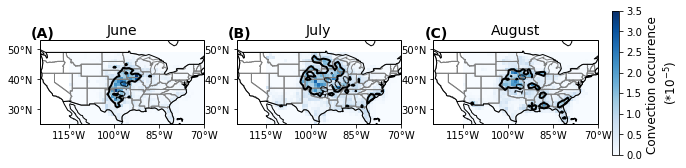

In [38]:
plt.figure(figsize=[10,4])
convs = [conv_jun,conv_jul,conv_aug]
titles = ['June','July','August','September']
for i in range(3):
    conv_plot(i,convs[i],titles[i])
    plt.text(232,54,'('+chr(65+i)+')',fontsize=14,fontweight='semibold',transform=ccrs.PlateCarree())

plt.tight_layout(rect = [0,0,0.9,1])

cax = plt.axes([0.92, 0.25, 0.01, 0.5])
import matplotlib.cm as cm
cmap = cm.Blues
norm = colors.Normalize(vmin=0, vmax=3.5)
cb1 = colorbar.ColorbarBase(cax, cmap=cmap,norm=norm)
cb1.set_label('Convection occurrence \n'+r'$(*10^{-5})$',fontsize=12)
#plt.savefig('/sn2/wyu/figures_for_monsoon_paper/supplement2.pdf')

In [104]:
def conv_posi_plot(i,lonGrid,latGrid,grid_conv,conv,h2o,title):
    ax1 = plt.subplot(1,3,i+1,projection=ccrs.PlateCarree(central_longitude=0)) 
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.add_feature(cfeature.STATES, edgecolor='grey')
    ax1.add_feature(cfeature.BORDERS, edgecolor='black')
    ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.set_extent((230,290,25,50))   
    ax1.set_yticks([30, 40, 50], crs=ccrs.PlateCarree())
    ax1.set_xticks([230, 260, 290], crs=ccrs.PlateCarree())
    cx=plt.pcolor(lonGrid,latGrid,grid_conv,cmap='YlOrRd',\
                  vmin=0,vmax=50*12,transform=ccrs.PlateCarree())
    CS = plt.contour(conv.Lon,conv.Lat,conv.mean(dim='Time').sel(Lev=100).values,levels=[1e-5],colors='k',\
                     linewidths=2,transform=ccrs.PlateCarree())
    levels2 = np.linspace(0,0.8,5)
    CS = ax1.contour(h2o.Lon.values,h2o.Lat.values,h2o.mean(dim='Time').sel(Lev=100).values\
                ,levels=levels2,linestyles='dashed',colors='k',transform=ccrs.PlateCarree(),linewidths = 1.5)
    plt.title(title,fontsize=15)
    plt.text(220,56,'('+chr(65+i)+')',fontsize=16,fontweight='semibold',transform=ccrs.PlateCarree())
    

/h/yuwandi/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


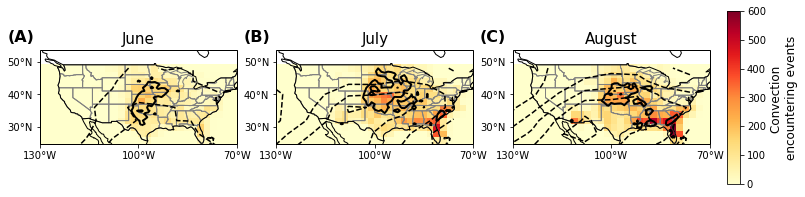

In [105]:
plt.figure(figsize=[12,4])
titles = ['June', 'July', 'August']
convs = [conv_jun,conv_jul,conv_aug]
h2os = [(h2o_jun-h2o_jun.mean(dim='Lon')).sel(Lon=slice(225,290), Lat=slice(10,50))\
        ,(h2o_jul-h2o_jul.mean(dim='Lon')).sel(Lon=slice(225,290), Lat=slice(10,50))\
          ,(h2o_aug-h2o_aug.mean(dim='Lon')).sel(Lon=slice(225,290), Lat=slice(10,50))]

for i in range(3):
    conv_posi_plot(i,lonGrid,latGrid,grid_conv.sum(axis=0)[i],\
                   convs[i],h2os[i],titles[i])

cax = plt.axes([0.92, 0.2, 0.015, 0.6])
import matplotlib.cm as cm
cmap = cm.YlOrRd
norm = colors.Normalize(vmin=0, vmax=50*12)
cb1 = colorbar.ColorbarBase(cax, cmap=cmap,norm=norm)
cb1.set_label('Convection \nencountering events',fontsize=12)
plt.tight_layout()
plt.savefig('/sn2/wyu/figures_for_monsoon_paper/supplement1.pdf')

In [131]:
lat_mins_monthly = [(lat_mins[:,i,:3].sum(axis=-1)/\
                     lat_mins[:,i].sum(axis=-1)) for i in range(3)]


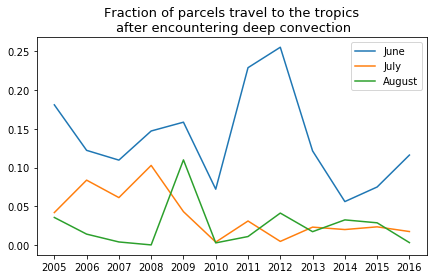

In [143]:
plt.figure(figsize=[7,4])
labels = ['June','July','August']
for i in range(3):
    plt.plot(np.arange(12)+2005,lat_mins_monthly[i],label=labels[i])
plt.xticks(np.arange(12)+2005);
plt.legend()
plt.title('Fraction of parcels travel to the tropics\n after encountering deep convection',fontsize=13)
plt.savefig('/sn2/wyu/figures_for_monsoon_paper/supplement3.pdf')

In [33]:
years = [str(2005+i) for i in range(12)]
months = [str(6+i).zfill(2) for i in range(3)]
windFolder = '/co1/hao/reanlys_raw2nc/ECMWF_ERAi/winds/'
U = []
V = []
for month in months:
    fs = []
    for year in years:
        fs += glob(windFolder+'ECMWF_ERAi_hybrid_6hr_UVQ_'+year+month+'??.nc')
    f = []
    for i in range(len(fs)):
        f += [xr.open_dataset(fs[i])]
    U += [xr.concat([f[i].u.sel(levels=25)for i in range(len(fs))]\
              ,dim='time').mean(dim='time')]
    V += [xr.concat([f[i].v.sel(levels=25) for i in range(len(fs))]\
              ,dim='time').mean(dim='time')]
X=xr.open_dataset(fs[i]).longitude.values
Y=xr.open_dataset(fs[i]).latitude.values

In [51]:
def conv_plot(i_fig,conv,h2o,title):
    co = 'Blues'
    lat=conv.Lat.values
    lon=conv.Lon.values
    levels = np.linspace(0,0.00004,50)
    levels2 = np.linspace(-0.95,0.95,11)
    vmax = 0.000035
    ax1 = plt.subplot(1,3,i_fig,projection=ccrs.PlateCarree(central_longitude=0)) 
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.add_feature(cfeature.STATES, edgecolor='grey')
    ax1.add_feature(cfeature.BORDERS, edgecolor='black')
    ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.set_extent((230,290,10,50))   
    ax1.set_yticks([0,10,20,30, 40, 50], crs=ccrs.PlateCarree())
    ax1.set_xticks([230,240,250, 260, 270, 280, 290], crs=ccrs.PlateCarree())
    CS = plt.contour(lon,lat,conv.mean(dim='Time').sel(Lev=100).values,levels=[1e-5],colors='k',\
                     linewidths=2,transform=ccrs.PlateCarree())
    cx = ax1.contourf(h2o.Lon.values,h2o.Lat.values,h2o.mean(dim='Time').sel(Lev=100).values\
                ,levels=levels2,cmap='bwr',transform=ccrs.PlateCarree())
    ax1.streamplot(X, Y, U[i_fig-1].values, V[i_fig-1].values, density=0.3, color='#333333',transform=ccrs.PlateCarree())
    #ax1.clabel(CS, inline=1, fmt='%1.1f',fontsize=10)
    ax1.set_title(title+' $H_2O$ anomaly',fontsize=14)
    return cx

/h/yuwandi/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/cartopy/vector_transform.py:140: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/cartopy/vector_transform.py:140: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ip

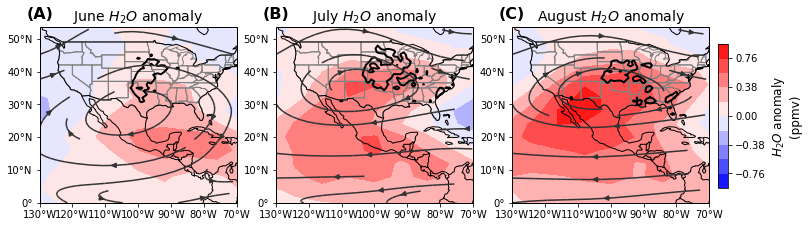

In [52]:
plt.figure(figsize=[12,5])
convs = [conv_jun,conv_jul,conv_aug]
h2os = [(h2o_jun-h2o_jun.mean(dim='Lon'))\
        ,(h2o_jul-h2o_jul.mean(dim='Lon'))\
          ,(h2o_aug-h2o_aug.mean(dim='Lon'))]
titles = ['June','July','August','September']

for i in range(3):
    cx = conv_plot(i+1,convs[i],h2os[i],titles[i])
    plt.text(226,56,'('+chr(65+i)+')',fontsize=16,fontweight='semibold',transform=ccrs.PlateCarree())
    fs = glob('/mnt/data/ice2/wyu/mls_l2/MLS_*0{}_global.nc'.format(str(i+6)))
    for ff in fs:
        f = xr.open_dataset(ff)
        i_over = np.where(f.h2o[:,12]>8)

import matplotlib.cm as cm
vmax = 1
cax = plt.axes([0.91, 0.3, 0.012, 0.4])
cb1 = plt.colorbar(cx,cax=cax)
cb1.set_label(r'$H_2O$'+' anomaly\n(ppmv)',fontsize=12)
plt.tight_layout()
plt.savefig('/sn2/wyu/figures_for_monsoon_paper/supplement5.pdf')

/h/yuwandi/miniconda3/lib/python3.7/site-packages/cartopy/vector_transform.py:140: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/cartopy/vector_transform.py:140: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/cartopy/vector_transform.py:140: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Tight layout not applied. The left and right marg

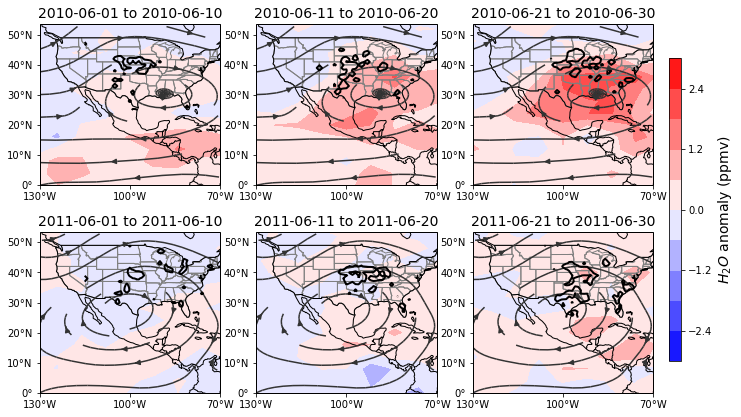

In [44]:
plt.figure(figsize=[11,7])
vmax = 3.
levels2 = np.linspace(-vmax,vmax,11)
year,month = '2010','06'
f = xr.open_dataset('/sn2/wyu/mls/encounter_events/encounter_events{}{}_30N.nc'.format(year,month))
fMLS = xr.open_dataset('/mnt/data/ice2/wyu/mls_l2/MLS_L2_{}{}_NA.nc'.format(year,month))
h2o_grid = (h2o_jun-h2o_jun.mean(dim='Lon')).sel(Lon=slice(220,300), \
        Lat=slice(0,60),Lev=100,Time=slice(year+'-06-01',year+'-06-30'))
conv_grid = conv_jun.sel(Time=slice(year+'-06-01',year+'-06-30'),Lev=100)
days = 10
for i in range(3):
    ax1 = plt.subplot(2,3,i+1,projection=ccrs.PlateCarree(central_longitude=0)) 
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.add_feature(cfeature.STATES, edgecolor='grey')
    ax1.add_feature(cfeature.BORDERS, edgecolor='black')
    ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.set_extent((230,290,0,50))   
    ax1.set_yticks([0,10,20,30, 40, 50], crs=ccrs.PlateCarree())
    ax1.set_xticks([230, 260, 290], crs=ccrs.PlateCarree())
    years = [str(2005+i) for i in range(12)]
    months = [str(6+i).zfill(2) for i in range(3)]
    windFolder = '/co1/hao/reanlys_raw2nc/ECMWF_ERAi/winds/'
    fs = glob(windFolder+'ECMWF_ERAi_hybrid_6hr_UVQ_'+year+month+'??.nc')
    f = []
    for iii in range(len(fs)):
        f += [xr.open_dataset(fs[iii])]
    U1 = xr.concat([f[i].u.sel(levels=25)for i in range(len(fs))]\
              ,dim='time').mean(dim='time').values
    V1 = xr.concat([f[i].v.sel(levels=25) for i in range(len(fs))]\
              ,dim='time').mean(dim='time').values
    X1=xr.open_dataset(fs[iii]).longitude.values
    Y1=xr.open_dataset(fs[iii]).latitude.values
    ax1.streamplot(X1, Y1, U1, V1, density=0.3, color='#333333',transform=ccrs.PlateCarree())
    #conv_grid.sel(Time=slice('2010-06-15','2010-06-20')).mean(dim='Time').plot(transform=ccrs.PlateCarree(),cmap='Blues')
    #h2o_grid.sel(Time=slice('2010-06-20','2010-06-25')).mean(dim='Time').plot(transform=ccrs.PlateCarree())    
    CS = plt.contour(conv_grid.Lon,conv_grid.Lat,conv_grid.sel\
    (Time=slice(year+'-06-'+str(i*days+1).zfill(2),year+'-06-'+str((i+1)*days).zfill(2))).mean(dim='Time').values,
        levels=[1e-5],colors='k',linewidths=2,transform=ccrs.PlateCarree())
    cx = plt.contourf(h2o_grid.Lon,h2o_grid.Lat,h2o_grid.sel\
    (Time=slice(year+'-06-'+str(i*days+1).zfill(2),year+'-06-'+str((i+1)*days).zfill(2))).mean(dim='Time').values\
            ,levels=levels2,cmap='bwr',transform=ccrs.PlateCarree())
    plt.title(year+'-06-'+str(i*days+1).zfill(2)+' to '+year+'-06-'+str((i+1)*days).zfill(2), fontsize=14)

year,month = '2011','06'
f = xr.open_dataset('/sn2/wyu/mls/encounter_events/encounter_events{}{}_30N.nc'.format(year,month))
fMLS = xr.open_dataset('/mnt/data/ice2/wyu/mls_l2/MLS_L2_{}{}_NA.nc'.format(year,month))
h2o_grid = (h2o_jun-h2o_jun.mean(dim='Lon')).sel(Lon=slice(220,300), \
        Lat=slice(0,60),Lev=100,Time=slice(year+'-06-01',year+'-06-30'))
conv_grid = conv_jun.sel(Time=slice(year+'-06-01',year+'-06-30'),Lev=100)

for i in range(3):
    ax1 = plt.subplot(2,3,i+4,projection=ccrs.PlateCarree(central_longitude=0)) 
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.add_feature(cfeature.STATES, edgecolor='grey')
    ax1.add_feature(cfeature.BORDERS, edgecolor='black')
    ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.set_extent((230,290,0,50))   
    ax1.set_yticks([0,10,20,30, 40, 50], crs=ccrs.PlateCarree())
    ax1.set_xticks([230, 260, 290], crs=ccrs.PlateCarree())
    windFolder = '/co1/hao/reanlys_raw2nc/ECMWF_ERAi/winds/'

    fs = glob(windFolder+'ECMWF_ERAi_hybrid_6hr_UVQ_'+year+month+'??.nc')
    f = []
    for iii in range(len(fs)):
        f += [xr.open_dataset(fs[iii])]
    U1 = xr.concat([f[i].u.sel(levels=25)for i in range(len(fs))]\
              ,dim='time').mean(dim='time').values
    V1 = xr.concat([f[i].v.sel(levels=25) for i in range(len(fs))]\
              ,dim='time').mean(dim='time').values
    X1=xr.open_dataset(fs[iii]).longitude.values
    Y1=xr.open_dataset(fs[iii]).latitude.values
    ax1.streamplot(X1, Y1, U1, V1, density=0.3, color='#333333',transform=ccrs.PlateCarree())
    #conv_grid.sel(Time=slice('2010-06-15','2010-06-20')).mean(dim='Time').plot(transform=ccrs.PlateCarree(),cmap='Blues')
    #h2o_grid.sel(Time=slice('2010-06-20','2010-06-25')).mean(dim='Time').plot(transform=ccrs.PlateCarree())    
    CS = plt.contour(conv_grid.Lon,conv_grid.Lat,conv_grid.sel\
    (Time=slice(year+'-06-'+str(i*days+1).zfill(2),year+'-06-'+str((i+1)*days).zfill(2))).mean(dim='Time').values,
        levels=[1e-5],colors='k',linewidths=2,transform=ccrs.PlateCarree())
    cx = plt.contourf(h2o_grid.Lon,h2o_grid.Lat,h2o_grid.sel\
    (Time=slice(year+'-06-'+str(i*days+1).zfill(2),year+'-06-'+str((i+1)*days).zfill(2))).mean(dim='Time').values\
            ,levels=levels2,cmap='bwr',transform=ccrs.PlateCarree())
    plt.title(year+'-06-'+str(i*days+1).zfill(2)+' to '+year+'-06-'+str((i+1)*days).zfill(2), fontsize=14)

    
plt.tight_layout()
import matplotlib.cm as cm
cmap = cm.bwr
cax = plt.axes([0.92, 0.2, 0.015, 0.6])
cb1 = plt.colorbar(cx,cax=cax)
cb1.set_label('$H_2O$ anomaly (ppmv)',fontsize=14)
#plt.savefig('/sn2/wyu/figures_for_monsoon_paper/supplement6.pdf')

In [2]:
fout = '/sn2/wyu/mls/parcel_history/parcel_source_2005-2016_MLS_monthly_5days_trajback.nc'
f = xr.open_dataset(fout)
f.close()

/h/yuwandi/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


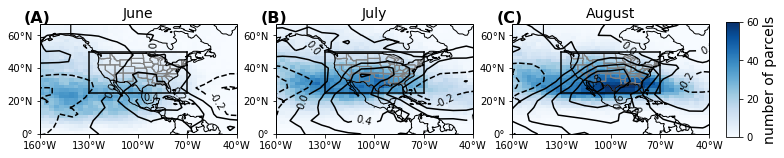

In [94]:
plt.figure(figsize=[12,4])
h2os = [(h2o_jun-h2o_jun.mean(dim='Lon'))\
        ,(h2o_jul-h2o_jul.mean(dim='Lon'))\
          ,(h2o_aug-h2o_aug.mean(dim='Lon'))]
levels2 = np.linspace(-1,1,11)
titles = ['June','July','August']
for i in range(3):
    h2o = h2os[i]
    ax1 = plt.subplot(1,3,i+1,projection=ccrs.PlateCarree(central_longitude=0)) 
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.add_feature(cfeature.STATES, edgecolor='grey')
    ax1.add_feature(cfeature.BORDERS, edgecolor='black')
    ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.set_extent((200,320,0,50))   
    ax1.set_yticks([0,20, 40, 60], crs=ccrs.PlateCarree())
    ax1.set_xticks([200,230, 260, 290,320], crs=ccrs.PlateCarree())
    source = f.mean(dim='Year').sel(Days=10,Month=i+6).Parcel_source
    cx = plt.pcolor(source.Lon,source.Lat,source.values,vmax=60,
               cmap='Blues',transform=ccrs.PlateCarree())
    plt.plot([230,230],[25,50],'k',transform=ccrs.PlateCarree())
    plt.plot([290,290],[25,50],'k',transform=ccrs.PlateCarree())
    plt.plot([230,290],[25,25],'k',transform=ccrs.PlateCarree())
    plt.plot([230,290],[50,50],'k',transform=ccrs.PlateCarree())
    CS = ax1.contour(h2o.Lon.values,h2o.Lat.values,h2o.mean(dim='Time').sel(Lev=100).values\
                ,levels=levels2,colors='k',transform=ccrs.PlateCarree())
    plt.clabel(CS, inline=1, fontsize=10,fmt='%1.1f',)
    
    plt.title(titles[i],fontsize=14)
    add_order(ax1,i)

plt.tight_layout()
import matplotlib.cm as cm
cmap = cm.bwr
cax = plt.axes([0.92, 0.3, 0.015, 0.4])
cb1 = plt.colorbar(cx,cax=cax)
cb1.set_label('number of parcels',fontsize=14)
plt.savefig('/sn2/wyu/figures_for_monsoon_paper/supplement7.pdf')

In [59]:
def h2o_plot(i_fig,h2o,title):

    levels2 = np.linspace(3.5,6.5,11)
    vmax = 0.000035
    ax1 = plt.subplot(1,3,i_fig,projection=ccrs.PlateCarree(central_longitude=0)) 
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.add_feature(cfeature.STATES, edgecolor='grey')
    ax1.add_feature(cfeature.BORDERS, edgecolor='black')
    ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.set_extent((230,290,25,50))   
    ax1.set_yticks([-20,-10,0,10,20,30, 40, 50], crs=ccrs.PlateCarree())
    ax1.set_xticks([230,240,250, 260, 270, 280, 290], crs=ccrs.PlateCarree())
    cx = ax1.contourf(h2o.Lon.values,h2o.Lat.values,h2o.values\
                ,levels=levels2,cmap='YlOrBr',transform=ccrs.PlateCarree())
    #ax1.clabel(CS, inline=1, fmt='%1.1f',fontsize=10)
    ax1.set_title(title+' $H_2O$ mixing ratio',fontsize=14)
    plt.text(220,56,'('+chr(65+i)+')',fontsize=16,fontweight='semibold',\
             transform=ccrs.PlateCarree())
    return cx

/h/yuwandi/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if sys.path[0] == '':
/h/yuwandi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  if sys.path[0] == '':


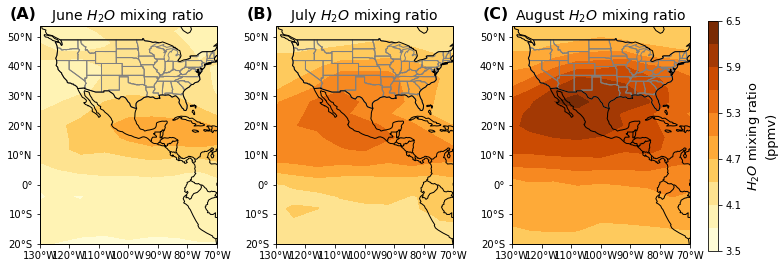

In [60]:
plt.figure(figsize=[12,4])
h2os = [h2o_jun,h2o_jul,h2o_aug]
titles = ['June','July','August','September']

for i in range(3):
    cx = h2o_plot(i+1,h2os[i].sel(Lev=100).mean(dim='Time'),titles[i])

vmax = 1
cax = plt.axes([0.91, 0.1, 0.012, 0.8])
cb1 = plt.colorbar(cx,cax=cax)
cb1.set_label(r'$H_2O$'+' mixing ratio\n(ppmv)',fontsize=13)
plt.tight_layout()
plt.savefig('/sn2/wyu/figures_for_monsoon_paper/supplement8.pdf')